<a href="https://colab.research.google.com/github/youngjae777/finance-optimization-ss-js-dcc-sharpe/blob/main/%ED%8C%803_%EC%9D%B8%ED%94%84%EB%9D%BC_%EC%82%AC%EA%B0%81%EC%A7%80%EB%8C%80_%ED%83%90%EC%A7%80_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8_%EA%B5%AC%EC%B6%95%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**데이터분석 프로그래밍 3조 발표자료**

초기 모델 코드 실행 및 분석

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box, Polygon
from pyproj import Transformer
from scipy.spatial import cKDTree
import numpy as np
import logging
from tqdm import tqdm
import warnings
import requests
import time
import re
warnings.filterwarnings('ignore')

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# 상수 설정
CONSTANTS = {
    'INPUT_FILE': "traffic_accident_data.csv",
    'SHAPE_FILE': "LARD_ADM_SECT_SGG_11_202505.shp",
    'OUTPUT_FILE': "격자_사고_cctv_검지기_포함.csv",
    'CCTV_FILE': "서울도시고속도로 교통CCTV 설치위치 정보_20250306.csv",
    'VDS_FILE': "서울도시고속도로 교통소통 영상검지기(VDS) 설치위치 정보.csv",
    'GRID_CONFIG': {
        'SIZE': 250,  # 격자 크기 (미터)
        'RANGE': 20000,  # 서울시청 기준 범위 (미터)
        'INTERVAL': 250,  # 격자 간격 (미터)
    },
    'CITY_HALL': {
        'LON': 126.9778222,  # 서울시청 경도
        'LAT': 37.5664056,   # 서울시청 위도
    },
    'KAKAO_API_KEY': "3a44c47a29be5f7bc9b9dd7cc8d6a8ff"  # 카카오 API 키
}

def verify_grid_size(gdf_grid, grid_size=250):
    """격자 크기 검증"""
    logging.info("\n=== 격자 크기 검증 시작 ===\n")
    # ... (기존 코드와 동일)
    try:
        # ... (기존 코드와 동일)
        return {
            'theoretical_area': theoretical_area,
            'mean_area': mean_area,
            'error_rate': error_rate
        }
    except Exception as e:
        logging.error(f"격자 크기 검증 중 오류 발생: {str(e)}")
        return None

def process_cctv_data(cctv_df, transformer):
    """CCTV 데이터 전처리 및 좌표 변환"""
    logging.info("CCTV 데이터 처리 시작")
    try:
        logging.info("CCTV 데이터 컬럼명:")
        logging.info(list(cctv_df.columns))
        lon_col = None
        lat_col = None
        for col in cctv_df.columns:
            if '경도' in col:
                lon_col = col
            elif '위도' in col:
                lat_col = col
        if lon_col is None or lat_col is None:
            logging.error("CCTV 데이터에서 경도 또는 위도 컬럼을 찾을 수 없습니다. 컬럼명을 확인해주세요.")
            return None
        cctv_df = cctv_df[[lat_col, lon_col]].copy()
        cctv_df = cctv_df.dropna(subset=[lat_col, lon_col])
        cctv_points = list(zip(cctv_df[lon_col], cctv_df[lat_col]))
        cctv_tm = np.array([transformer.transform(x, y) for x, y in tqdm(cctv_points, desc="CCTV 좌표 변환 중")])
        logging.info(f"CCTV 데이터 처리 완료: {len(cctv_tm)}개")
        return cctv_tm
    except Exception as e:
        logging.error(f"CCTV 데이터 처리 중 오류 발생: {str(e)}")
        logging.info("CCTV 데이터의 실제 컬럼명을 확인해주세요.")
        return None

def process_detector_data(detector_df, transformer):
    """검지기 데이터 전처리 및 좌표 변환"""
    logging.info("검지기 데이터 처리 시작")
    try:
        logging.info("검지기 데이터 컬럼명:")
        logging.info(list(detector_df.columns))
        if 'XPOINT' not in detector_df.columns or 'YPOINT' not in detector_df.columns:
            logging.error("검지기 데이터에서 'XPOINT' 또는 'YPOINT' 컬럼을 찾을 수 없습니다. 컬럼명을 확인해주세요.")
            return None
        detector_df = detector_df[['YPOINT', 'XPOINT']].copy()
        detector_df = detector_df.dropna(subset=['YPOINT', 'XPOINT'])
        # NaN 또는 Inf 값 필터링
        detector_df = detector_df[pd.notna(detector_df['XPOINT']) & pd.notna(detector_df['YPOINT'])]
        detector_df = detector_df[np.isfinite(detector_df['XPOINT']) & np.isfinite(detector_df['YPOINT'])]
        detector_points = list(zip(detector_df['XPOINT'], detector_df['YPOINT']))
        detector_tm = np.array([transformer.transform(x, y) for x, y in tqdm(detector_points, desc="검지기 좌표 변환 중")])
        logging.info(f"검지기 데이터 처리 완료: {len(detector_tm)}개")
        return detector_tm
    except Exception as e:
        logging.error(f"검지기 데이터 처리 중 오류 발생: {str(e)}")
        logging.info("검지기 데이터의 실제 컬럼명을 확인해주세요.")
        return None

def main():
    try:
        logging.info("프로그램 시작")

        # 1. 데이터 로드
        df = pd.read_csv(CONSTANTS['INPUT_FILE'], low_memory=False)
        logging.info(f"교통사고 데이터 로드 완료: {len(df)}건")

        # 서울시 행정구역 경계 로드
        seoul_boundary = gpd.read_file(CONSTANTS['SHAPE_FILE']).to_crs(epsg=4326)
        seoul_boundary = seoul_boundary.dissolve()  # 모든 구를 하나의 경계로 합치기

        # 서울시 범위로 데이터 필터링
        df = df[
            (df['X'] >= seoul_boundary.total_bounds[0]) &
            (df['X'] <= seoul_boundary.total_bounds[2]) &
            (df['Y'] >= seoul_boundary.total_bounds[1]) &
            (df['Y'] <= seoul_boundary.total_bounds[3])
        ].copy()
        logging.info(f"서울시 범위 내 사고 데이터: {len(df)}건")

        # 2. CCTV 데이터 로드
        encodings = ['utf-8-sig', 'euc-kr', 'cp949', 'utf-8']
        cctv_df = None
        for encoding in encodings:
            try:
                cctv_df = pd.read_csv(CONSTANTS['CCTV_FILE'], encoding=encoding)
                logging.info(f"CCTV 파일을 {encoding} 인코딩으로 성공적으로 읽었습니다.")
                break
            except UnicodeDecodeError:
                continue
        if cctv_df is None:
            raise Exception("CCTV 파일을 읽을 수 없습니다. 파일 인코딩을 확인해주세요.")

        # CCTV 데이터 전처리 개선
        cctv_df = cctv_df.dropna(subset=[cctv_df.columns[2], cctv_df.columns[3]])
        cctv_df = cctv_df[
            (cctv_df.iloc[:, 2] >= seoul_boundary.total_bounds[0]) &
            (cctv_df.iloc[:, 2] <= seoul_boundary.total_bounds[2]) &
            (cctv_df.iloc[:, 3] >= seoul_boundary.total_bounds[1]) &
            (cctv_df.iloc[:, 3] <= seoul_boundary.total_bounds[3])
        ]
        print(f"\nCCTV 총 개수: {len(cctv_df):,}개")
        print(f"CCTV 경도 범위: {cctv_df.iloc[:, 2].min():.6f} ~ {cctv_df.iloc[:, 2].max():.6f}")
        print(f"CCTV 위도 범위: {cctv_df.iloc[:, 3].min():.6f} ~ {cctv_df.iloc[:, 3].max():.6f}")

        # 3. VDS 데이터 로드
        vds_df = None
        for encoding in encodings:
            try:
                vds_df = pd.read_csv(CONSTANTS['VDS_FILE'], encoding=encoding)
                logging.info(f"VDS 파일을 {encoding} 인코딩으로 성공적으로 읽었습니다.")
                break
            except UnicodeDecodeError:
                continue
        if vds_df is None:
            raise Exception("VDS 파일을 읽을 수 없습니다. 파일 인코딩을 확인해주세요.")

        # VDS 데이터 전처리 개선
        vds_df = vds_df.dropna(subset=['XPOINT', 'YPOINT'])
        vds_df = vds_df[
            (vds_df['XPOINT'] >= seoul_boundary.total_bounds[0]) &
            (vds_df['XPOINT'] <= seoul_boundary.total_bounds[2]) &
            (vds_df['YPOINT'] >= seoul_boundary.total_bounds[1]) &
            (vds_df['YPOINT'] <= seoul_boundary.total_bounds[3])
        ]
        print(f"\nVDS 총 개수: {len(vds_df):,}개")
        print(f"VDS 경도 범위: {vds_df['XPOINT'].min():.6f} ~ {vds_df['XPOINT'].max():.6f}")
        print(f"VDS 위도 범위: {vds_df['YPOINT'].min():.6f} ~ {vds_df['YPOINT'].max():.6f}")

        # 4. 좌표계 변환 준비
        transformer_to_tm = Transformer.from_crs("epsg:4326", "epsg:5181", always_xy=True)
        transformer_to_wgs = Transformer.from_crs("epsg:5181", "epsg:4326", always_xy=True)

        # 5. 격자 생성
        logging.info("격자 생성 시작")
        cityhall_x, cityhall_y = transformer_to_tm.transform(
            CONSTANTS['CITY_HALL']['LON'],
            CONSTANTS['CITY_HALL']['LAT']
        )

        # 서울시청 기준으로 격자 생성
        grid_range = CONSTANTS['GRID_CONFIG']['RANGE']
        interval = CONSTANTS['GRID_CONFIG']['INTERVAL']

        x_range = np.arange(cityhall_x - grid_range, cityhall_x + grid_range + interval, interval)
        y_range = np.arange(cityhall_y - grid_range, cityhall_y + grid_range + interval, interval)

        grid_list = []
        grid_id = 1

        for y in y_range:
            for x in x_range:
                lon, lat = transformer_to_wgs.transform(x, y)
                grid_list.append((grid_id, x, y, lon, lat))
                grid_id += 1

        df_grid = pd.DataFrame(grid_list, columns=["GRID_ID", "X_CENTER_TM", "Y_CENTER_TM", "LONGITUDE", "LATITUDE"])
        logging.info(f"초기 격자 생성 완료: {len(df_grid)}개")

        # 6. 사고 데이터 격자 매핑
        logging.info("교통사고 좌표 변환 및 격자 매핑 시작")

        # 사고 데이터는 X(경도), Y(위도) 컬럼 사용, TM 좌표계로 변환
        logging.info(f"사고 데이터 경도/위도 범위:")
        logging.info(f"경도 범위: {df['X'].min():.6f} ~ {df['X'].max():.6f}")
        logging.info(f"위도 범위: {df['Y'].min():.6f} ~ {df['Y'].max():.6f}")

        accident_points = list(zip(df["X"], df["Y"]))  # 경도, 위도
        accident_tm = np.array([transformer_to_tm.transform(lon, lat) for lon, lat in tqdm(accident_points, desc="교통사고 좌표 변환 중")])
        if len(accident_tm) == 0:
            raise Exception("좌표 변환된 사고 데이터가 없습니다.")

        logging.info(f"좌표 변환된 사고 데이터 수: {len(accident_tm)}건")
        logging.info(f"TM 좌표 범위:")
        logging.info(f"X 범위: {accident_tm[:, 0].min():.2f} ~ {accident_tm[:, 0].max():.2f}")
        logging.info(f"Y 범위: {accident_tm[:, 1].min():.2f} ~ {accident_tm[:, 1].max():.2f}")

        # 격자 중심점과의 거리 계산
        tree = cKDTree(df_grid[["X_CENTER_TM", "Y_CENTER_TM"]].values)
        distances, indices = tree.query(accident_tm)

        # 매핑 거리 제한을 격자 간격으로 설정
        valid_accidents = distances <= CONSTANTS['GRID_CONFIG']['INTERVAL']
        df = df[valid_accidents].copy()
        df["GRID_ID"] = df_grid.loc[indices[valid_accidents], "GRID_ID"].values

        logging.info(f"유효한 격자에 매핑된 사고 건수: {len(df)}건")
        logging.info(f"매핑되지 않은 사고 건수: {len(accident_tm) - len(df)}건")

        if len(df) == 0:
            logging.error("매핑된 사고 데이터가 없습니다. 좌표계를 확인해주세요.")
            raise Exception("사고 데이터 매핑 실패")

        # 7. CCTV 격자 매핑
        logging.info("CCTV 좌표 변환 및 매핑 시작")
        cctv_points = list(zip(cctv_df.iloc[:, 2], cctv_df.iloc[:, 3]))  # 경도, 위도
        cctv_tm = []
        for lon, lat in tqdm(cctv_points, desc="CCTV 좌표 변환 중"):
            try:
                x, y = transformer_to_tm.transform(lon, lat)
                if np.isfinite(x) and np.isfinite(y):
                    cctv_tm.append([x, y])
            except Exception as e:
                logging.warning(f"CCTV 좌표 변환 실패: {lon}, {lat}, 오류: {str(e)}")
                continue
        cctv_tm = np.array(cctv_tm)
        _, cctv_indices = tree.query(cctv_tm)
        cctv_counts = pd.Series(cctv_indices).value_counts()
        df_grid['CCTV_COUNT'] = 0
        df_grid.loc[cctv_counts.index, 'CCTV_COUNT'] = cctv_counts.values
        logging.info(f"CCTV 매핑 완료: {len(cctv_tm)}개")

        # 8. VDS 격자 매핑
        logging.info("VDS 좌표 변환 및 매핑 시작")
        vds_points = list(zip(vds_df['XPOINT'], vds_df['YPOINT']))  # 경도, 위도
        vds_tm = []
        for lon, lat in tqdm(vds_points, desc="VDS 좌표 변환 중"):
            try:
                x, y = transformer_to_tm.transform(lon, lat)
                if np.isfinite(x) and np.isfinite(y):
                    vds_tm.append([x, y])
            except Exception as e:
                logging.warning(f"VDS 좌표 변환 실패: {lon}, {lat}, 오류: {str(e)}")
                continue
        vds_tm = np.array(vds_tm)
        _, vds_indices = tree.query(vds_tm)
        vds_counts = pd.Series(vds_indices).value_counts()
        df_grid['VDS_COUNT'] = 0
        df_grid.loc[vds_counts.index, 'VDS_COUNT'] = vds_counts.values
        logging.info(f"VDS 매핑 완료: {len(vds_tm)}개")



       # 8-1. 횡단보도 CSV 로드 및 매핑 시작
        logging.info("횡단보도 CSV 로드 및 매핑 시작")
        cw_file = "서울특별시_자치구별 신호등 및 횡단보도 위치 및 현황_20230530.csv"
        cw_df = pd.read_csv(cw_file, encoding='utf-8-sig')

        # X/Y 좌표 컬럼 찾기
        if 'X좌표' in cw_df.columns and 'Y좌표' in cw_df.columns:
            coords_df = cw_df[['X좌표', 'Y좌표']].copy()
        else:
            x_col = cw_df.columns[6]
            y_col = cw_df.columns[7]
            coords_df = cw_df[[x_col, y_col]].copy()

        # 숫자 아닌 값 제거
        coords_df = coords_df.apply(pd.to_numeric, errors='coerce').dropna()

        # 좌표 배열
        cw_coords = coords_df.values

        # 좌표계 변환기: EPSG:5186 → EPSG:5181
        transformer_cw = Transformer.from_crs("EPSG:5186", "EPSG:5181", always_xy=True)

        # 좌표 변환 수행
        cw_tm = []
        for x, y in tqdm(cw_coords, desc="횡단보도 좌표 변환 중"):
            try:
                xtm, ytm = transformer_cw.transform(x, y)
                if np.isfinite(xtm) and np.isfinite(ytm):
                    cw_tm.append([xtm, ytm])
            except Exception as e:
                logging.warning(f"횡단보도 좌표 변환 실패: {x}, {y}, {e}")
        cw_tm = np.array(cw_tm)

        # KD-Tree로 격자 매핑
        if len(cw_tm) > 0:
            _, cw_idx = tree.query(cw_tm)
            cw_counts = pd.Series(cw_idx).value_counts()
            df_grid['CROSSWALK_COUNT'] = 0
            df_grid.loc[cw_counts.index, 'CROSSWALK_COUNT'] = cw_counts.values
            logging.info(f"횡단보도 매핑 완료: {len(cw_tm)}개")
        else:
            df_grid['CROSSWALK_COUNT'] = 0
            logging.warning("횡단보도 좌표 데이터가 없습니다.")




        # 9. 격자별 사고 건수 집계
        count = df.groupby("GRID_ID").size().reset_index(name="ACCIDENT_COUNT")
        df_grid = df_grid.merge(count, on="GRID_ID", how="left").fillna(0)
        df_grid["ACCIDENT_COUNT"] = df_grid["ACCIDENT_COUNT"].astype(int)

        # 10. 버스정류장 데이터 로드 및 격자 매핑
        bus_stop_file = "서울시버스정류소위치정보(20250513).csv"
        try:
            # 여러 인코딩 시도
            encodings = ['utf-8-sig', 'euc-kr', 'cp949', 'utf-8']
            bus_df = None
            for encoding in encodings:
                try:
                    bus_df = pd.read_csv(bus_stop_file, encoding=encoding)
                    logging.info(f"버스정류장 파일을 {encoding} 인코딩으로 성공적으로 읽었습니다.")
                    break
                except UnicodeDecodeError:
                    continue

            if bus_df is None:
                raise Exception("버스정류장 파일을 읽을 수 없습니다. 파일 인코딩을 확인해주세요.")

            # 컬럼명 확인 및 출력
            print("\n버스정류장 데이터 컬럼명:")
            print(bus_df.columns.tolist())

            # 경도/위도 컬럼 찾기
            lon_col = None
            lat_col = None
            for col in bus_df.columns:
                if '경도' in col or 'X' in col or 'x' in col or 'lon' in col.lower():
                    lon_col = col
                elif '위도' in col or 'Y' in col or 'y' in col or 'lat' in col.lower():
                    lat_col = col

            if lon_col is None or lat_col is None:
                raise Exception("버스정류장 데이터에서 경도 또는 위도 컬럼을 찾을 수 없습니다.")

            print(f"경도 컬럼: {lon_col}, 위도 컬럼: {lat_col}")

            # 데이터 전처리
            bus_df = bus_df.dropna(subset=[lon_col, lat_col])
            bus_df = bus_df[
                (bus_df[lon_col] >= seoul_boundary.total_bounds[0]) &
                (bus_df[lon_col] <= seoul_boundary.total_bounds[2]) &
                (bus_df[lat_col] >= seoul_boundary.total_bounds[1]) &
                (bus_df[lat_col] <= seoul_boundary.total_bounds[3])
            ]

            print(f"\n버스정류장 총 개수: {len(bus_df):,}개")
            print(f"경도 범위: {bus_df[lon_col].min():.6f} ~ {bus_df[lon_col].max():.6f}")
            print(f"위도 범위: {bus_df[lat_col].min():.6f} ~ {bus_df[lat_col].max():.6f}")

            # 좌표 변환 및 매핑
            bus_points = list(zip(bus_df[lon_col], bus_df[lat_col]))
            bus_tm = []
            for lon, lat in tqdm(bus_points, desc="버스정류장 좌표 변환 중"):
                try:
                    x, y = transformer_to_tm.transform(lon, lat)
                    if np.isfinite(x) and np.isfinite(y):
                        bus_tm.append([x, y])
                except Exception as e:
                    logging.warning(f"버스정류장 좌표 변환 실패: {lon}, {lat}, 오류: {str(e)}")
                    continue
            bus_tm = np.array(bus_tm)
            _, bus_indices = tree.query(bus_tm)
            bus_counts = pd.Series(bus_indices).value_counts()
            df_grid['BUS_STOP_COUNT'] = 0
            df_grid.loc[bus_counts.index, 'BUS_STOP_COUNT'] = bus_counts.values
            logging.info(f"버스정류장 매핑 완료: {len(bus_tm)}개")
        except FileNotFoundError:
            logging.warning(f"버스정류장 파일을 찾을 수 없습니다: {bus_stop_file}")
            df_grid['BUS_STOP_COUNT'] = 0
            print("버스정류장 데이터를 0으로 설정했습니다.")
        except Exception as e:
            logging.error(f"버스정류장 데이터 처리 중 오류 발생: {str(e)}")
            df_grid['BUS_STOP_COUNT'] = 0
            print("버스정류장 데이터를 0으로 설정했습니다.")

        # === 버스정류장 승하차 인원 격자별 집계 ===
        # 1. 버스정류장 위치 데이터 로드 및 격자 매핑
        bus_stop_file = "서울시버스정류소위치정보(20250513).csv"
        bus_df = pd.read_csv(bus_stop_file, encoding='cp949')  # 인코딩은 상황에 맞게 조정

        # 정류장명(3번 컬럼), 경도(4번), 위도(5번) 추출
        bus_df['정류장명'] = bus_df.iloc[:, 2]
        bus_df['경도'] = bus_df.iloc[:, 3]
        bus_df['위도'] = bus_df.iloc[:, 4]

        # 좌표 변환 및 격자 매핑
        bus_points = list(zip(bus_df['경도'], bus_df['위도']))
        bus_tm = [transformer_to_tm.transform(lon, lat) for lon, lat in bus_points]
        bus_df['X_TM'], bus_df['Y_TM'] = zip(*bus_tm)
        bus_tm_arr = np.array(bus_tm)
        _, bus_indices = tree.query(bus_tm_arr)
        bus_df['GRID_ID'] = df_grid.loc[bus_indices, 'GRID_ID'].values

        # 격자별 정류장명 리스트 저장 (코드 내에서만 사용)
        grid_to_stops = bus_df.groupby('GRID_ID')['정류장명'].apply(list).to_dict()

        # 2. 승하차 인원 데이터 로드 및 정류장명 기준 집계
        ridership_file = "2025년_버스노선별_정류장별_시간대별_승하차_인원_정보(04월).csv"
        ridership_df = pd.read_csv(ridership_file, encoding='cp949')  # 인코딩은 상황에 맞게 조정
        ridership_df['정류장명'] = ridership_df.iloc[:, 5]  # 6번째 컬럼(0-indexed)
        # 7~54번 컬럼(0-indexed 6~53) 합계
        ridership_df['승하차합'] = ridership_df.iloc[:, 6:54].sum(axis=1)

        def clean_stop_name(name):
            if pd.isnull(name):
                return ""
            name = str(name).strip().lower()
            name = re.sub(r'[^가-힣a-zA-Z0-9]', '', name)
            return name

        # 버스정류장 위치 데이터
        bus_df['정류장명_clean'] = bus_df['정류장명'].apply(clean_stop_name)

        # 승하차 인원 데이터
        ridership_df['정류장명_clean'] = ridership_df['정류장명'].apply(clean_stop_name)

        # ARS_ID(정류장 고유번호)로 매칭하여 승하차 인원 집계
        # 1. bus_df에서 ARS_ID 추출 (2번째 컬럼)
        bus_df['ARS_ID'] = bus_df.iloc[:, 1].astype(str).str.strip()

        # 2. ridership_df에서 ARS_ID 추출 (5번째 컬럼)
        ridership_df['ARS_ID'] = ridership_df.iloc[:, 4].astype(str).str.strip()

        # 3. 승하차합 집계
        ridership_sum = ridership_df.groupby('ARS_ID')['승하차합'].sum().reset_index()

        # 4. 격자별 ARS_ID 리스트
        grid_to_stops = bus_df.groupby('GRID_ID')['ARS_ID'].apply(list).to_dict()

        def sum_ridership(stop_ars_ids):
            matched = ridership_sum[ridership_sum['ARS_ID'].isin(stop_ars_ids)]
            return matched['승하차합'].sum()

        df_grid['BUS_STOP_RIDERSHIP'] = df_grid['GRID_ID'].apply(
            lambda gid: sum_ridership(grid_to_stops.get(gid, []))
        )

        # === 신호등 데이터 처리 및 격자 매핑 ===
        signal_file = "서울특별시_신호등 데이터_20230403.csv"
        try:
            encodings = ['utf-8-sig', 'euc-kr', 'cp949', 'utf-8']
            signal_df = None
            for encoding in encodings:
                try:
                    signal_df = pd.read_csv(signal_file, encoding=encoding)
                    logging.info(f"신호등 파일을 {encoding} 인코딩으로 성공적으로 읽었습니다.")
                    break
                except UnicodeDecodeError:
                    continue
            if signal_df is None:
                raise Exception("신호등 파일을 읽을 수 없습니다. 파일 인코딩을 확인해주세요.")

            print("신호등 데이터 컬럼명:", signal_df.columns.tolist())
            x_col = signal_df.columns[5]  # 6번째 컬럼
            y_col = signal_df.columns[6]  # 7번째 컬럼

            signal_df = signal_df.dropna(subset=[x_col, y_col])
            transformer_signal = Transformer.from_crs("epsg:5186", "epsg:5181", always_xy=True)
            signal_tm_5181 = signal_df[[x_col, y_col]].apply(lambda row: transformer_signal.transform(row[x_col], row[y_col]), axis=1)
            signal_df['X_TM5181'] = [pt[0] for pt in signal_tm_5181]
            signal_df['Y_TM5181'] = [pt[1] for pt in signal_tm_5181]

            seoul_tm_bounds = seoul_boundary.to_crs(epsg=5181).total_bounds
            signal_df = signal_df[
                (signal_df['X_TM5181'] >= seoul_tm_bounds[0]) &
                (signal_df['X_TM5181'] <= seoul_tm_bounds[2]) &
                (signal_df['Y_TM5181'] >= seoul_tm_bounds[1]) &
                (signal_df['Y_TM5181'] <= seoul_tm_bounds[3])
            ]
            if len(signal_df) > 0:
                signal_tm = signal_df[['X_TM5181', 'Y_TM5181']].values
                _, signal_indices = tree.query(signal_tm)
                signal_counts = pd.Series(signal_indices).value_counts()
                df_grid['SIGNAL_COUNT'] = 0
                df_grid.loc[signal_counts.index, 'SIGNAL_COUNT'] = signal_counts.values
                logging.info(f"신호등 매핑 완료: {len(signal_tm)}개")
            else:
                df_grid['SIGNAL_COUNT'] = 0
                print("신호등 데이터가 없습니다. 0으로 설정합니다.")
        except FileNotFoundError:
            logging.warning(f"신호등 파일을 찾을 수 없습니다: {signal_file}")
            df_grid['SIGNAL_COUNT'] = 0
            print("신호등 데이터를 0으로 설정했습니다.")
        except Exception as e:
            logging.error(f"신호등 데이터 처리 중 오류 발생: {str(e)}")
            df_grid['SIGNAL_COUNT'] = 0
            print("신호등 데이터를 0으로 설정했습니다.")



        # === 교차로 데이터 처리 및 격자 매핑 (EPSG:5186 → 5181 변환) ===
        intersection_file = "서울시 교차로 관련 정보.csv"
        try:
            encodings = ['utf-8-sig', 'euc-kr', 'cp949', 'utf-8']
            intersection_df = None
            for encoding in encodings:
                try:
                    intersection_df = pd.read_csv(intersection_file, encoding=encoding)
                    logging.info(f"교차로 파일을 {encoding} 인코딩으로 성공적으로 읽었습니다.")
                    break
                except UnicodeDecodeError:
                    continue
            if intersection_df is None:
                raise Exception("교차로 파일을 읽을 수 없습니다. 파일 인코딩을 확인해주세요.")

            print("교차로 데이터 컬럼명:", intersection_df.columns.tolist())
            x_col = intersection_df.columns[23]  # 24번째 컬럼 (0-indexed)
            y_col = intersection_df.columns[24]  # 25번째 컬럼 (0-indexed)

            # float 변환
            intersection_df[x_col] = pd.to_numeric(intersection_df[x_col], errors='coerce')
            intersection_df[y_col] = pd.to_numeric(intersection_df[y_col], errors='coerce')
            intersection_df = intersection_df.dropna(subset=[x_col, y_col])
            print("교차로 데이터 개수(필터 후):", len(intersection_df))

            # EPSG:5186 → EPSG:5181 변환
            transformer_5186_to_5181 = Transformer.from_crs("epsg:5186", "epsg:5181", always_xy=True)
            intersection_df['X_TM5181'], intersection_df['Y_TM5181'] = zip(*intersection_df[[x_col, y_col]].apply(
                lambda row: transformer_5186_to_5181.transform(row[x_col], row[y_col]), axis=1
            ))
            x_col_new = 'X_TM5181'
            y_col_new = 'Y_TM5181'

            # 서울시 TM 경계 내 필터링
            seoul_tm_bounds = seoul_boundary.to_crs(epsg=5181).total_bounds
            print("서울시 TM 경계:", seoul_tm_bounds)
            intersection_df = intersection_df[
                (intersection_df[x_col_new] >= seoul_tm_bounds[0]) &
                (intersection_df[x_col_new] <= seoul_tm_bounds[2]) &
                (intersection_df[y_col_new] >= seoul_tm_bounds[1]) &
                (intersection_df[y_col_new] <= seoul_tm_bounds[3])
            ]
            print("교차로 데이터 개수(서울시 TM 경계 내):", len(intersection_df))

            if len(intersection_df) > 0:
                intersection_tm = intersection_df[[x_col_new, y_col_new]].values
                _, intersection_indices = tree.query(intersection_tm)
                intersection_counts = pd.Series(intersection_indices).value_counts()
                df_grid['INTERSECTION_COUNT'] = 0
                df_grid.loc[intersection_counts.index, 'INTERSECTION_COUNT'] = intersection_counts.values
                print("INTERSECTION_COUNT 분포:", df_grid['INTERSECTION_COUNT'].value_counts())
                logging.info(f"교차로 매핑 완료: {len(intersection_tm)}개")
            else:
                df_grid['INTERSECTION_COUNT'] = 0
                print("교차로 데이터가 없습니다. 0으로 설정합니다.")
        except FileNotFoundError:
            logging.warning(f"교차로 파일을 찾을 수 없습니다: {intersection_file}")
            df_grid['INTERSECTION_COUNT'] = 0
            print("교차로 데이터를 0으로 설정했습니다.")
        except Exception as e:
            logging.error(f"교차로 데이터 처리 중 오류 발생: {str(e)}")
            df_grid['INTERSECTION_COUNT'] = 0
            print("교차로 데이터를 0으로 설정했습니다.")


        # 공간조인 전 컬럼 확인
        print("공간조인 전 df_grid.columns:", df_grid.columns)
        print("BUS_STOP_COUNT 샘플:", df_grid['BUS_STOP_COUNT'].head() if 'BUS_STOP_COUNT' in df_grid.columns else '없음')
        print("SIGNAL_COUNT 샘플:", df_grid['SIGNAL_COUNT'].head() if 'SIGNAL_COUNT' in df_grid.columns else '없음')
        print("INTERSECTION_COUNT 샘플:", df_grid['INTERSECTION_COUNT'].head() if 'INTERSECTION_COUNT' in df_grid.columns else '없음')

        # 12. geometry 생성 및 GeoDataFrame 변환
        df_grid["geometry"] = [Point(x, y) for x, y in zip(df_grid["X_CENTER_TM"], df_grid["Y_CENTER_TM"])]
        gdf_grid = gpd.GeoDataFrame(df_grid, geometry="geometry", crs="EPSG:5181")

        # 13. 자치구 shp 파일 불러오기
        try:
            gu = gpd.read_file(CONSTANTS['SHAPE_FILE']).to_crs(epsg=5181)
        except Exception as e:
            logging.error(f"자치구 shp 파일 로드 중 오류 발생: {str(e)}")
            gu = None

        # 14. 공간 조인 (서울시 구 폴리곤 내부만 남김)
        if gu is not None:
            joined = gpd.sjoin(gdf_grid, gu[["SGG_NM", "geometry"]], how="inner", predicate="within")
            joined["SGG_NM"] = joined["SGG_NM"].fillna("외부지역")
            logging.info("공간 조인 완료")
        else:
            joined = gdf_grid.copy()
            joined["SGG_NM"] = "정보없음"

        # 컬럼명, 타입 확인용 print
        print("공간조인 후 joined.columns:", joined.columns)
        print("df_grid.columns:", df_grid.columns)
        print("joined['GRID_ID'] dtype:", joined['GRID_ID'].dtype)
        print("df_grid['GRID_ID'] dtype:", df_grid['GRID_ID'].dtype)

        # SIGNAL_COUNT, INTERSECTION_COUNT 컬럼이 없으면 0으로 추가
        for col in ['SIGNAL_COUNT', 'INTERSECTION_COUNT']:
            if col not in joined.columns:
                if col in df_grid.columns:
                    joined = joined.merge(df_grid[['GRID_ID', col]], on='GRID_ID', how='left')
                    joined[col] = joined[col].fillna(0).astype(int)
                else:
                    joined[col] = 0

        final_cols = [
            "GRID_ID", "LONGITUDE", "LATITUDE", "X_CENTER_TM", "Y_CENTER_TM",
            "ACCIDENT_COUNT", "CCTV_COUNT", "VDS_COUNT",
            "BUS_STOP_COUNT", "BUS_STOP_RIDERSHIP",
            "SIGNAL_COUNT", "INTERSECTION_COUNT",
            "CROSSWALK_COUNT",
            "SGG_NM"
        ]

        final_df = joined[final_cols].copy()
        final_df.to_csv("격자_사고_cctv_검지기_역_포함.csv", index=False, encoding="utf-8-sig")
        logging.info(f"최종 결과 저장 완료: 격자_사고_cctv_검지기_역_포함.csv")

        # 16. CCTV/VDS 분포 출력
        print("\n격자별 CCTV 개수 분포:")
        cctv_distribution = final_df['CCTV_COUNT'].value_counts().sort_index()
        for count, num_grids in cctv_distribution.items():
            print(f"CCTV {count}개 있는 격자: {num_grids:,}개")
        print("\n격자별 VDS 개수 분포:")
        vds_distribution = final_df['VDS_COUNT'].value_counts().sort_index()
        for count, num_grids in vds_distribution.items():
            print(f"VDS {count}개 있는 격자: {num_grids:,}개")

        # 17. 교통사고 횟수 총합 출력
        print(f"\n교통사고 횟수 총합: {final_df['ACCIDENT_COUNT'].sum():,}건")

        # 18. CCTV와 VDS 총 개수 출력
        print(f"\nCCTV 총 개수: {final_df['CCTV_COUNT'].sum():,}개")
        print(f"VDS 총 개수: {final_df['VDS_COUNT'].sum():,}개")
        print(f"버스정류장 총 개수: {final_df['BUS_STOP_COUNT'].sum():,}개")
        print(f"신호등 총 개수: {final_df['SIGNAL_COUNT'].sum():,}개")
        print(f"교차로 총 개수: {final_df['INTERSECTION_COUNT'].sum():,}개")

        # === 인프라/센서 등급 산정 ===
        # 1. 각 항목 정규화
        norm_cols = []
        for col in ['CCTV_COUNT', 'VDS_COUNT', 'SIGNAL_COUNT', 'BUS_STOP_COUNT', 'INTERSECTION_COUNT']:
            norm_col = f'norm_{col}'
            norm_cols.append(norm_col)
            min_v = final_df[col].min()
            max_v = final_df[col].max()
            if max_v > min_v:
                final_df[norm_col] = (final_df[col] - min_v) / (max_v - min_v)
            else:
                final_df[norm_col] = 0
        # 2. 합산 점수 계산
        final_df['infra_score'] = final_df[norm_cols].sum(axis=1)
        # 3. 등급 부여 (bin 수와 label 수가 맞지 않을 때 오류 방지)
        try:
            cats, bins = pd.qcut(final_df['infra_score'], 5, retbins=True, duplicates='drop')
            n_bins = len(bins) - 1
            if n_bins < 2:
                final_df['INFRA_GRADE'] = 1
            else:
                labels = list(range(1, n_bins+1))
                final_df['INFRA_GRADE'] = pd.qcut(final_df['infra_score'], q=n_bins, labels=labels, duplicates='drop')
        except Exception as e:
            print('등급 산정 오류:', e)
            final_df['INFRA_GRADE'] = 1
        print('등급별 격자 수:')
        print(final_df['INFRA_GRADE'].value_counts().sort_index())
        print('등급별 점수 구간:')
        for grade in final_df['INFRA_GRADE'].unique():
            score_min = final_df[final_df['INFRA_GRADE'] == grade]['infra_score'].min()
            score_max = final_df[final_df['INFRA_GRADE'] == grade]['infra_score'].max()
            print(f"{grade}등급: 점수 {score_min:.2f} ~ {score_max:.2f}")
        # 4. 등급 컬럼을 맨 마지막으로 이동
        cols = list(final_df.columns)
        if cols[-1] != 'INFRA_GRADE':
            cols = [c for c in cols if c != 'INFRA_GRADE'] + ['INFRA_GRADE']
            final_df = final_df[cols]

        logging.info("프로그램 종료")

    except Exception as e:
        logging.error(f"처리 중 오류 발생: {str(e)}")
        raise

if __name__ == "__main__":
    main()


CCTV 총 개수: 920개
CCTV 경도 범위: 126.784250 ~ 127.179150
CCTV 위도 범위: 37.437900 ~ 37.692830

VDS 총 개수: 379개
VDS 경도 범위: 126.829550 ~ 127.152540
VDS 위도 범위: 37.471260 ~ 37.680160


횡단보도 좌표 변환 중: 100%|██████████| 39036/39036 [00:00<00:00, 72642.24it/s]



버스정류장 데이터 컬럼명:
['NODE_ID', 'ARS_ID', '정류소명', 'X좌표', 'Y좌표', '정류소타입']
경도 컬럼: X좌표, 위도 컬럼: Y좌표

버스정류장 총 개수: 11,299개
경도 범위: 126.797494 ~ 127.181785
위도 범위: 37.430520 ~ 37.690177


버스정류장 좌표 변환 중: 100%|██████████| 11299/11299 [00:00<00:00, 141753.03it/s]


신호등 데이터 컬럼명: ['순번', '시도명', '시군구명', '도로종류', '주소', 'X좌표', 'Y좌표', '부착형태', '관리번호', '신호등종류', '광원종류', '음향신호기 유무', '잔여시간 유무', '보행자작동신호기 유무']
교차로 데이터 컬럼명: ['교차로코드', '입력일자', '교차로명칭', '유형코드', '연동교차로코드', '구코드 (공통);', '지번', '구경찰서 (공통);', '신경찰서 (공통);', '작업구분 (공통);', '표출구분 (공통);', '고객번호', '계약종별', '계량기번호', '도로구분 (공통);', '관할사업소 (공통);', '교차로관리번호', '공간데이터', '신규정규화ID', '이력ID', '동코드 (공통);', '공사형태 (공통);', '지도표출구분', 'X좌표', 'Y좌표']
교차로 데이터 개수(필터 후): 8103
서울시 TM 경계: [179191.37599067 436562.79901027 216242.25304652 466863.54424789]
교차로 데이터 개수(서울시 TM 경계 내): 8101
INTERSECTION_COUNT 분포: INTERSECTION_COUNT
0    21488
1     2033
2     1480
3      640
4      224
5       49
7        3
6        3
8        1
Name: count, dtype: int64
공간조인 전 df_grid.columns: Index(['GRID_ID', 'X_CENTER_TM', 'Y_CENTER_TM', 'LONGITUDE', 'LATITUDE',
       'CCTV_COUNT', 'VDS_COUNT', 'CROSSWALK_COUNT', 'ACCIDENT_COUNT',
       'BUS_STOP_COUNT', 'BUS_STOP_RIDERSHIP', 'SIGNAL_COUNT',
       'INTERSECTION_COUNT'],
      dtype='object')
BUS_STOP

▶ 스크립트 시작
데이터 로드: 9686개 행
결측치 제거 후: 9686개 행
비도시 추정 셀 제거 수: 3125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 7
[LightGBM] [Info] Start training from score -1.197894
[LightGBM] [Info] Start training from score -1.155255
[LightGBM] [Info] Start training from score -1.407088
[LightGBM] [Info] Start training from score -2.099458
[LightGBM] [Info] Start training from score -4.146762
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's multi_logloss: 1.1248	training's multi_error: 0.45846	valid_1's multi_logloss: 1.20655	valid_1's multi_error: 0.531607

=== Confusion Matrix & Classification Report ===
              precision    recall  f1-score   support

           1      0.585     0.702     0.638  

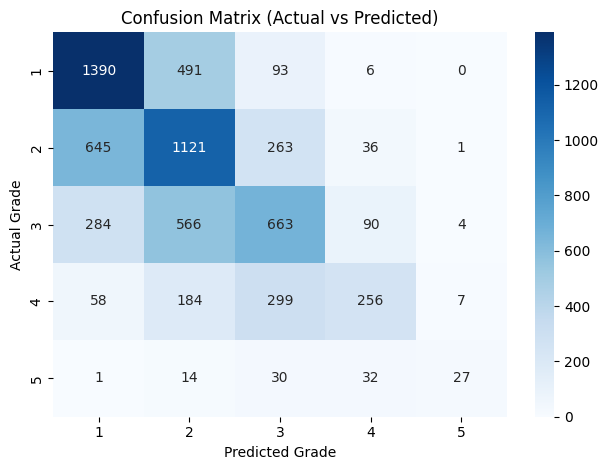


=== 등급별 정확도 분석 ===
Grade 1 (G1) → 총 1980개 중 1390개 정확히 예측 | 정확도: 70.2%
Grade 2 (G2) → 총 2066개 중 1121개 정확히 예측 | 정확도: 54.3%
Grade 3 (G3) → 총 1607개 중 663개 정확히 예측 | 정확도: 41.3%
Grade 4 (G4) → 총 804개 중 256개 정확히 예측 | 정확도: 31.8%
Grade 5 (G5) → 총 104개 중 27개 정확히 예측 | 정확도: 26.0%

전체 평균 정확도: 52.7%
센서 사각지대 셀 수: 60
파일 생성 확인: risk_alert_zones_map.html 있음


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os

def main():
    print("▶ 스크립트 시작")

    # 1. 데이터 로드 및 결측치 제거
    df = pd.read_csv("격자_사고_cctv_검지기_역_포함.csv", encoding="utf-8-sig")
    print(f"데이터 로드: {len(df)}개 행")
    feature_cols = [
        "CCTV_COUNT", "VDS_COUNT", "BUS_STOP_COUNT", "BUS_STOP_RIDERSHIP",
        "SIGNAL_COUNT", "INTERSECTION_COUNT", "CROSSWALK_COUNT"
    ]
    target_col = "ACCIDENT_COUNT"
    df = df.dropna(subset=feature_cols + [target_col])
    print(f"결측치 제거 후: {len(df)}개 행")

    # 2. 사고건수 기반 위험 등급 분류
    df["log_acc"] = np.log1p(df[target_col])
    df["risk_grade"] = pd.cut(df["log_acc"], bins=5, labels=[1, 2, 3, 4, 5], include_lowest=True).astype(int)

    # 2.5. 인프라가 전무한 G1 격자 제거
    df["infra_sum"] = df[feature_cols].sum(axis=1)
    mask = (df["risk_grade"] == 1) & (df["infra_sum"] == 0)
    print("비도시 추정 셀 제거 수:", mask.sum())
    df = df[~mask]

    # 3. 학습/검증 분할
    X_train, X_val, y_train, y_val = train_test_split(
        df[feature_cols],
        df["risk_grade"],
        test_size=0.2,
        random_state=42,
        stratify=df["risk_grade"]
    )

    # 4. 모델 학습
    model = LGBMClassifier(objective="multiclass", num_class=5, n_estimators=1000, random_state=42)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric=["multi_logloss", "multi_error"],
        callbacks=[early_stopping(50), log_evaluation(100)]
    )

    # 5. 예측 수행
    df["pred_grade"] = model.predict(df[feature_cols])

    # 6. 혼동 행렬 및 시각화
    print("\n=== Confusion Matrix & Classification Report ===")
    print(classification_report(df["risk_grade"], df["pred_grade"], digits=3))
    cmatrix = confusion_matrix(df["risk_grade"], df["pred_grade"], labels=[1, 2, 3, 4, 5])
    sns.heatmap(cmatrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(1, 6), yticklabels=range(1, 6))
    plt.xlabel("Predicted Grade")
    plt.ylabel("Actual Grade")
    plt.title("Confusion Matrix (Actual vs Predicted)")
    plt.tight_layout()
    plt.show()

    # 7. 등급별 정확도 분석
    print("\n=== 등급별 정확도 분석 ===")
    total_correct = 0
    total_samples = 0
    for i in range(5):
        actual_total = cmatrix[i].sum()
        correct = cmatrix[i, i]
        accuracy = correct / actual_total * 100 if actual_total > 0 else 0
        print(f"Grade {i+1} (G{i+1}) → 총 {actual_total}개 중 {correct}개 정확히 예측 | 정확도: {accuracy:.1f}%")
        total_correct += correct
        total_samples += actual_total
    overall_accuracy = total_correct / total_samples * 100
    print(f"\n전체 평균 정확도: {overall_accuracy:.1f}%")

    # 8. 센서 사각지대(G3~G4 예측 + 인프라 부족) 정의
    infra_thresh = df["infra_sum"].quantile(0.3)
    df["alert_zone"] = df["pred_grade"].isin([3, 4]) & (df["infra_sum"] <= infra_thresh)

    # 9. 지도 시각화 (Folium)
    cmap = cm.get_cmap("RdYlBu_r", 5)
    norm = mcolors.Normalize(vmin=1, vmax=5)
    m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)
    delta_lat = 0.00225
    delta_lon = 0.0028

    for _, row in df.iterrows():
        lat = row["LATITUDE"]
        lon = row["LONGITUDE"]
        sw = [lat - delta_lat / 2, lon - delta_lon / 2]
        ne = [lat + delta_lat / 2, lon + delta_lon / 2]
        if row["alert_zone"]:
            color = "#00FF00"
        else:
            grade = int(row["pred_grade"])
            color = mcolors.rgb2hex(cmap(norm(grade)))
        folium.Rectangle(
            bounds=[sw, ne],
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=(f"GID: {row['GRID_ID']}<br>PredGrade: {row['pred_grade']}<br>InfraSum: {row['infra_sum']:.1f}")
        ).add_to(m)

    # 10. 범례 추가
    legend_html = '''
      <div style="
        position: fixed;
        bottom: 50px; left: 50px;
        width: 180px; height: 200px;
        background-color: white;
        border:2px solid grey;
        z-index:9999;
        font-size:14px;
        padding: 10px;
      ">
        <b>Risk Grade</b><br>
    '''
    for g in range(1, 6):
        c = mcolors.rgb2hex(cmap(norm(g)))
        legend_html += f'<i style="background:{c};width:18px;height:18px;display:inline-block;margin-right:8px;"></i> Grade {g}<br>'
    legend_html += '<i style="background:#00FF00;width:18px;height:18px;display:inline-block;margin-right:8px;"></i> 센서 사각지대<br>'
    legend_html += '</div>'
    m.get_root().html.add_child(folium.Element(legend_html))

    # 11. 저장 및 확인 출력
    print("센서 사각지대 셀 수:", df["alert_zone"].sum())
    m.save("risk_alert_zones_map.html")
    if os.path.exists("risk_alert_zones_map.html"):
        print("파일 생성 확인: risk_alert_zones_map.html 있음")
    else:
        print("파일 없음: 저장 실패")

if __name__ == "__main__":
    main()


생성된 risk_alert_zones_map.html를 서울 구 위도 경도 정보를 가져와 html 파일을 수정해 구단위로 경계선을 그어봅니다.

추가된 코드는 다음과 같습니다.

(function() {
    // southkorea/seoul-maps 레포의 KOSTAT 2013 GeoJSON (자치구 경계)
    var guGeojsonUrl = "https://raw.githubusercontent.com/southkorea/seoul-maps/refs/heads/master/juso/2015/json/seoul_municipalities_geo.json";

    // folium이 생성한 전역 지도 객체 이름 추정: map_********
    // 이 파일 안에는 하나의 L.map(...)만 있으므로, window 객체에서 자동 탐색
    var targetMap = null;
    for (var k in window) {
        if (window.hasOwnProperty(k) && k.indexOf("map_") === 0 && window[k] instanceof L.Map) {
            targetMap = window[k];
            break;
        }
    }

    if (!targetMap) {
        console.error("서울 자치구 경계: Leaflet 지도 객체(map_***)를 찾지 못했습니다.");
        return;
    }

    function guStyle(feature) {
        return {
            weight: 2,
            opacity: 1,
            color: "#111111",
            fillOpacity: 0.0,
            fillColor: "#ffffff"
        };
    }

    function guHighlight(e) {
        var layer = e.target;
        layer.setStyle({
            weight: 3,
            color: "#ff6600",
            fillOpacity: 0.15
        });
        if (!L.Browser.ie && !L.Browser.opera && !L.Browser.edge) {
            layer.bringToFront();
        }
    }

    function guReset(e) {
        if (guGeoJsonLayer) {
            guGeoJsonLayer.resetStyle(e.target);
        }
    }

    function guOnEach(feature, layer) {
        var props = feature.properties || {};
        var guName = props.SIG_KOR_NM || props.name || props.adm_nm || "미상 자치구";
        layer.bindPopup("<b>" + guName + "</b>");
        layer.on({
            mouseover: guHighlight,
            mouseout: guReset
        });
    }

    var guGeoJsonLayer = null;

    fetch(guGeojsonUrl)
        .then(function(response) {
            if (!response.ok) {
                throw new Error("서울 자치구 GeoJSON을 불러오지 못했습니다: " + response.status);
            }
            return response.json();
        })
        .then(function(data) {
            guGeoJsonLayer = L.geoJSON(data, {
                style: guStyle,
                onEachFeature: guOnEach
            }).addTo(targetMap);
            console.log("서울 자치구 경계가 위험도 지도 위에 오버레이되었습니다.");
        })
        .catch(function(err) {
            console.error(err);
            alert("서울 자치구 경계(GeoJSON)를 불러오는 중 오류가 발생했습니다.\\n인터넷 연결과 GitHub raw URL 접근 가능 여부를 확인해 주세요.");
        });
})();

격자단위별 등급 위치정보를 grid_predgrade_with_coords.csv로 만들어서 저장하고 그 데이터를 통해서 구 단위 평균 위험도를 파일을 생성합니다.

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 1) 격자 데이터 로드
df = pd.read_csv("grid_predgrade_with_coords.csv")

# 2) 격자 중심점을 Point geometry로 변환
gdf_grid = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon_center"], df["lat_center"]),
    crs="EPSG:4326",  # 위경도
)

# 3) 서울 자치구 경계 GeoJSON (인터넷/로컬 경로)
gu_geo_url = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"
gdf_gu = gpd.read_file(gu_geo_url)

# 4) 좌표계 맞추기 (필요 시)
gdf_gu = gdf_gu.to_crs(gdf_grid.crs)

# 5) 공간 조인: 격자 중심점이 어느 구 polygon 안에 들어가는지
gdf_joined = gpd.sjoin(gdf_grid, gdf_gu, predicate="within")

# 6) 구 단위 평균 grade 계산 (SIG_KOR_NM 기준)
gu_avg = (
    gdf_joined.groupby("name")["PredGrade"]
    .mean()
    .reset_index()
    .rename(columns={"name": "GU_NAME", "PredGrade": "AVG_PRED_GRADE"})
)

gu_avg.to_csv("gu_avg_predgrade.csv", index=False, encoding="utf-8-sig")
print(gu_avg.head())


  GU_NAME  AVG_PRED_GRADE
0     강남구        2.004283
1     강동구        1.814332
2     강북구        2.102703
3     강서구        1.885442
4     관악구        1.920930


**"위험도가 왜 그런 패턴을 보이는가??"**

- 인구구성

- 치안인프라

- 유동/주거/직장 인구

- 공연시설

- 불법주정치신고데이터


# 1. 인구구성

## 1-1. 서울 인구 데이터 전처리

**서울시 인구데이터 전처리**

:서울시 인구 데이터는 이중 헤더 구조 -> 컬럼 처리가 어려움.

상위/하위 헤더를 합쳐서 변수들을 뽑아냄

Households → 세대수

Total_Pop → 총인구

Foreigners → 등록외국인 수

People_per_HH → 세대당 인구

Senior_65p → 65세 이상 고령자 수

**인구 + 초기 위험도 병합**

초기 모델에서 만든 구 단위 평균 위험등급(AVG_GRADE)을
인구 데이터와 merge하여 분석 테이블이 완성

| 자치구 | 인구 | 세대수 | 외국인수 | 고령자수 | 세대당 인구 | AVG_GRADE |



**데이터 로딩)**
구글 드라이브에 있는 인구 CSV 파일을 pandas로 불러와서, 처음 5행을 확인

In [ ]:
import pandas as pd

pop_path = "/content/drive/MyDrive/등록인구_20251129123122.csv"
risk_path = "/content/drive/MyDrive/구 단위 평균 위험도.csv"

##header=None -> 위 3줄이 전부 헤더, 자동 헤더를 쓰지 않고 나중에 직접 조합하기 위해서
pop_raw = pd.read_csv(pop_path, header=None, encoding="utf-8-sig")

print("원본 상위 5행:")
display(pop_raw.head())

원본 상위 5행:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,동별(1),동별(2),2025 3/4,2025 3/4,2025 3/4,2025 3/4,2025 3/4,2025 3/4,2025 3/4,2025 3/4,2025 3/4,2025 3/4,2025 3/4,2025 3/4
1,동별(1),동별(2),세대 (세대),계 (명),계 (명),계 (명),한국인 (명),한국인 (명),한국인 (명),등록외국인 (명),등록외국인 (명),등록외국인 (명),세대당인구 (명),65세이상고령자 (명)
2,동별(1),동별(2),소계,소계,남자,여자,소계,남자,여자,소계,남자,여자,소계,소계
3,합계,소계,4505357,9594329,4610784,4983545,9318500,4491997,4826503,275829,118787,157042,2.07,1894245
4,합계,종로구,72402,149165,70897,78268,137545,66032,71513,11620,4865,6755,1.90,30658


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**서울** 25개 구의 인구데이터와 평균위험도를 한 파일에 합친 CSV를 생성한다

In [ ]:
# 0행: 연도/분기 (2025 3/4 ...)
# 1행: 상위 헤더 (세대 (세대), 계 (명)...)
# 2행: 하위 헤더 (소계, 남자, 여자...)
header_level1 = pop_raw.iloc[1]  # 세대 (세대), 계 (명), ...
header_level2 = pop_raw.iloc[2]  # 소계, 소계, 남자, 여자, ...

# --- 3. 2줄 헤더 합쳐서 컬럼 이름 만들기 ---
combined_cols = []
for c1, c2 in zip(header_level1, header_level2):
    c1 = str(c1)
    c2 = str(c2)
    if c1 in ["동별(1)", "동별(2)"]:
        combined_cols.append(c1)
    else:
        combined_cols.append(f"{c1}_{c2}")

print("\n생성된 컬럼 이름:")
print(combined_cols)

# --- 4. 실제 데이터 부분만 떼기
pop_df = pop_raw.iloc[3:].copy()
pop_df.columns = combined_cols

print("\n헤더 정리 후 상위 5행:")
display(pop_df.head())


##=======================================================================
# --- 5. 위험도 데이터 읽기 ---
risk_df = pd.read_csv(risk_path, encoding="utf-8-sig")
risk_df = risk_df.rename(columns={"행정구역": "GU", "평균 위험도": "AVG_GRADE"})

print("\n구 단위 평균 위험도 데이터:")
display(risk_df.head())

# --- 6. 서울 25개 구만 필터링 ---(isin)
gu_list = risk_df["GU"].unique()
pop_seoul_gu = pop_df[pop_df["동별(2)"].isin(gu_list)].copy()
pop_seoul_gu = pop_seoul_gu.rename(columns={"동별(2)": "GU"})

print("\n서울 25개 구만 남긴 인구 데이터 (일부):")
display(pop_seoul_gu.head())

# --- 7. 쓸 컬럼 선택 + 이름 변경 ---(rename_map)
rename_map = {
    "세대 (세대)_소계": "Households",          # 세대수
    "계 (명)_소계": "Total_Pop",              # 총 인구
    "등록외국인 (명)_소계": "Foreigners",     # 등록외국인 수
    "세대당인구 (명)_소계": "People_per_HH",  # 세대당 인구
    "65세이상고령자 (명)_소계": "Senior_65p", # 65세 이상 고령자 수
}

available_cols = {k: v for k, v in rename_map.items() if k in pop_seoul_gu.columns}
print("\n실제로 존재하는 원본 컬럼들:")
print(list(available_cols.keys()))

pop_seoul_gu = pop_seoul_gu[["GU"] + list(available_cols.keys())].rename(columns=available_cols)

print("\n컬럼 정리 후 인구 데이터:")
display(pop_seoul_gu.head())

# --- 8. 숫자형 변환 ---(콤마제거, 숫자형)
num_cols = ["Households", "Total_Pop", "Foreigners", "People_per_HH", "Senior_65p"]
for col in num_cols:
    if col in pop_seoul_gu.columns:
        pop_seoul_gu[col] = (
            pop_seoul_gu[col]
            .astype(str)
            .str.replace(",", "", regex=False)
            .str.strip()
        )
        if col == "People_per_HH":
            pop_seoul_gu[col] = pop_seoul_gu[col].astype(float)
        else:
            pop_seoul_gu[col] = pop_seoul_gu[col].astype(int)

print("\n숫자형 변환 후 info:")
print(pop_seoul_gu.info())
display(pop_seoul_gu.head())

##================================================================
# --- 9. 인구 + 위험도 병합 ---
merged = pd.merge(pop_seoul_gu, risk_df, on="GU", how="inner")

print("\n최종 '구 단위 인구 + 평균 위험도' 테이블:")
display(merged.head())
print("\n행 개수:", len(merged))

# --- 10. CSV로 저장 ---
merged.to_csv("gu_population_with_risk.csv", index=False, encoding="utf-8-sig")
print("\n[저장 완료] gu_population_with_risk.csv")


생성된 컬럼 이름:
['동별(1)', '동별(2)', '세대 (세대)_소계', '계 (명)_소계', '계 (명)_남자', '계 (명)_여자', '한국인 (명)_소계', '한국인 (명)_남자', '한국인 (명)_여자', '등록외국인 (명)_소계', '등록외국인 (명)_남자', '등록외국인 (명)_여자', '세대당인구 (명)_소계', '65세이상고령자 (명)_소계']

헤더 정리 후 상위 5행:


,동별(1),동별(2),세대 (세대)_소계,계 (명)_소계,계 (명)_남자,계 (명)_여자,한국인 (명)_소계,한국인 (명)_남자,한국인 (명)_여자,등록외국인 (명)_소계,등록외국인 (명)_남자,등록외국인 (명)_여자,세대당인구 (명)_소계,65세이상고령자 (명)_소계
3,합계,소계,4505357,9594329,4610784,4983545,9318500,4491997,4826503,275829,118787,157042,2.07,1894245
4,합계,종로구,72402,149165,70897,78268,137545,66032,71513,11620,4865,6755,1.90,30658
5,합계,중구,64259,128942,61743,67199,118458,56869,61589,10484,4874,5610,1.84,27442
6,합계,용산구,103187,215716,103377,112339,202636,96590,106046,13080,6787,6293,1.96,40342
7,합계,성동구,132994,282288,135903,146385,274195,132518,141677,8093,3385,4708,2.06,52896



구 단위 평균 위험도 데이터:


,GU,AVG_GRADE
0,강남구,2.022587
1,강동구,1.834951
2,강북구,2.120482
3,강서구,1.850667
4,관악구,1.911290



서울 25개 구만 남긴 인구 데이터 (일부):


,동별(1),GU,세대 (세대)_소계,계 (명)_소계,계 (명)_남자,계 (명)_여자,한국인 (명)_소계,한국인 (명)_남자,한국인 (명)_여자,등록외국인 (명)_소계,등록외국인 (명)_남자,등록외국인 (명)_여자,세대당인구 (명)_소계,65세이상고령자 (명)_소계
4,합계,종로구,72402,149165,70897,78268,137545,66032,71513,11620,4865,6755,1.90,30658
5,합계,중구,64259,128942,61743,67199,118458,56869,61589,10484,4874,5610,1.84,27442
6,합계,용산구,103187,215716,103377,112339,202636,96590,106046,13080,6787,6293,1.96,40342
7,합계,성동구,132994,282288,135903,146385,274195,132518,141677,8093,3385,4708,2.06,52896
8,합계,광진구,171265,349963,166279,183684,332072,158955,173117,17891,7324,10567,1.94,62240



실제로 존재하는 원본 컬럼들:
['세대 (세대)_소계', '계 (명)_소계', '등록외국인 (명)_소계', '세대당인구 (명)_소계', '65세이상고령자 (명)_소계']

컬럼 정리 후 인구 데이터:


,GU,Households,Total_Pop,Foreigners,People_per_HH,Senior_65p
4,종로구,72402,149165,11620,1.90,30658
5,중구,64259,128942,10484,1.84,27442
6,용산구,103187,215716,13080,1.96,40342
7,성동구,132994,282288,8093,2.06,52896
8,광진구,171265,349963,17891,1.94,62240



숫자형 변환 후 info:
<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 4 to 28
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GU             25 non-null     object 
 1   Households     25 non-null     int64  
 2   Total_Pop      25 non-null     int64  
 3   Foreigners     25 non-null     int64  
 4   People_per_HH  25 non-null     float64
 5   Senior_65p     25 non-null     int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 1.4+ KB
None


,GU,Households,Total_Pop,Foreigners,People_per_HH,Senior_65p
4,종로구,72402,149165,11620,1.90,30658
5,중구,64259,128942,10484,1.84,27442
6,용산구,103187,215716,13080,1.96,40342
7,성동구,132994,282288,8093,2.06,52896
8,광진구,171265,349963,17891,1.94,62240



최종 '구 단위 인구 + 평균 위험도' 테이블:


,GU,Households,Total_Pop,Foreigners,People_per_HH,Senior_65p,AVG_GRADE
0,종로구,72402,149165,11620,1.90,30658,1.918103
1,중구,64259,128942,10484,1.84,27442,2.433566
2,용산구,103187,215716,13080,1.96,40342,2.070175
3,성동구,132994,282288,8093,2.06,52896,2.004695
4,광진구,171265,349963,17891,1.94,62240,2.000000



행 개수: 25

[저장 완료] gu_population_with_risk.csv


**이제 “서울의 인구 구조가 사고 위험도와 어떤 관계가 있는가?”를 분석할 수 있게 되었습니다.**

# 1-2. 상관 분석 _ "어떤 요인이 위험도와 연결되는가?"

최종 병합된 데이터(서울 구 인구 + 위험도) 를 불러와서

→ 각 변수들 사이의 상관관계를 계산하고,

→ 특히 ‘평균 위험도(AVG_GRADE)’와 어떤 인구 지표가 가장 관련이 있는지 분석


In [ ]:
import pandas as pd

df = pd.read_csv("gu_population_with_risk.csv", encoding="utf-8-sig")
print(df.columns)
display(df.head())

num_cols = ["Households", "Total_Pop", "Foreigners", "People_per_HH", "Senior_65p", "AVG_GRADE"]
corr = df[num_cols].corr()

print("\n=== 상관계수 행렬 ===")
print(corr)

target_corr = corr["AVG_GRADE"].drop("AVG_GRADE")
print("\n=== AVG_GRADE와의 상관계수 ===")
print(target_corr.sort_values(ascending=False))

Index(['GU', 'Households', 'Total_Pop', 'Foreigners', 'People_per_HH',
       'Senior_65p', 'AVG_GRADE'],
      dtype='object')


,GU,Households,Total_Pop,Foreigners,People_per_HH,Senior_65p,AVG_GRADE
0,종로구,72402,149165,11620,1.90,30658,1.918103
1,중구,64259,128942,10484,1.84,27442,2.433566
2,용산구,103187,215716,13080,1.96,40342,2.070175
3,성동구,132994,282288,8093,2.06,52896,2.004695
4,광진구,171265,349963,17891,1.94,62240,2.000000



=== 상관계수 행렬 ===
               Households  Total_Pop  Foreigners  People_per_HH  Senior_65p  \
Households       1.000000   0.965177   -0.084894       0.258705    0.913962   
Total_Pop        0.965177   1.000000   -0.202921       0.488671    0.941280   
Foreigners      -0.084894  -0.202921    1.000000      -0.590926   -0.279493   
People_per_HH    0.258705   0.488671   -0.590926       1.000000    0.468557   
Senior_65p       0.913962   0.941280   -0.279493       0.468557    1.000000   
AVG_GRADE       -0.478313  -0.509989    0.313080      -0.390769   -0.519455   

               AVG_GRADE  
Households     -0.478313  
Total_Pop      -0.509989  
Foreigners      0.313080  
People_per_HH  -0.390769  
Senior_65p     -0.519455  
AVG_GRADE       1.000000  

=== AVG_GRADE와의 상관계수 ===
Foreigners       0.313080
People_per_HH   -0.390769
Households      -0.478313
Total_Pop       -0.509989
Senior_65p      -0.519455
Name: AVG_GRADE, dtype: float64


평균 위험도(AVG_GRADE)는 고령자 수, 총 인구, 세대수, 세대당 인구와 모두 음의 상관을 보임

즉,**인구 규모가 크고 안정적인 주거 중심 지역일수록 위험도가 낮다는 의미로 해석할 수 있음.**

반면 **외국인 수는 위험도와 양의 상관을 보여 외국인 거주 비중이 높은 지역이 비교적 위험도가 높은 경향**을 보임.

특히, 고령자 수(Senior_65p)와의 상관이 가장 강함(-0.519) →
**고령층이 많이 정착해있는 지역일수록 상대적으로 위험요인이 낮게 평가됨**을 시사한다.


# 1-3. 히트맵 생성

seaborn의 heatmap()

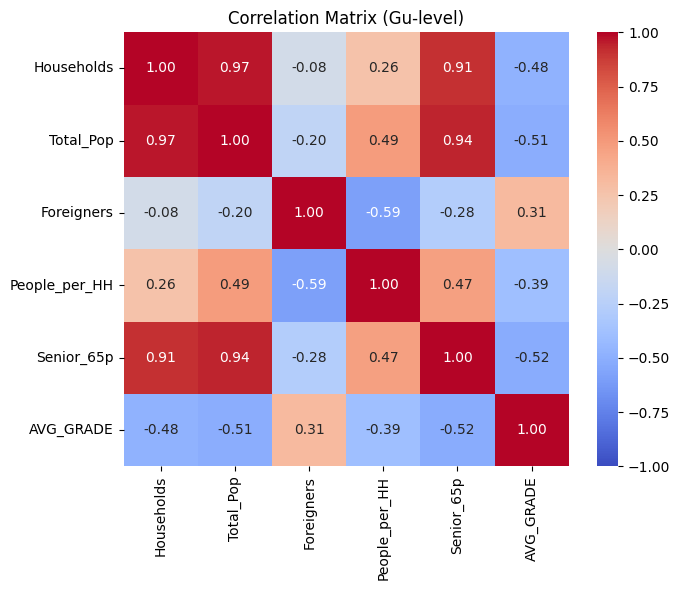

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix (Gu-level)")
plt.tight_layout()
plt.show()

음의 상관) 고령자, 세대수, 총인구, 세대당 인구는

양의 상관) 외국인

# 1-4. 산점도 + 회귀선

변수(key_features) 와
평균 위험도(AVG_GRADE) 사이의 관계를 **산점도 + 추세선(회귀선) 형태**로 시각화
_regplot()

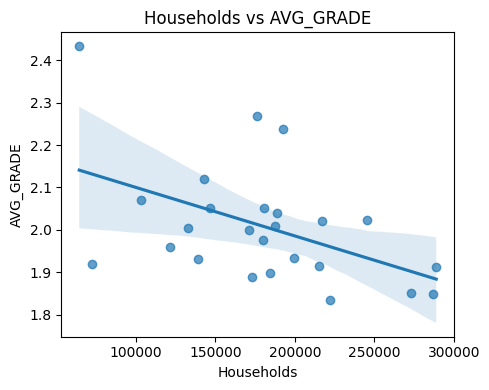

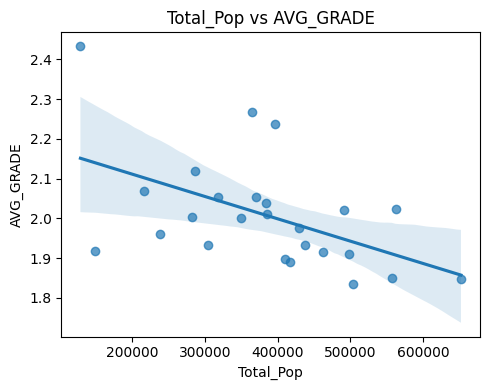

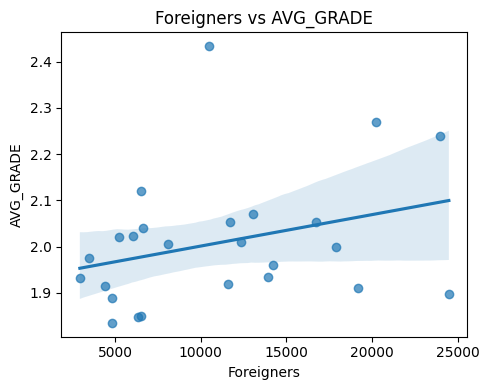

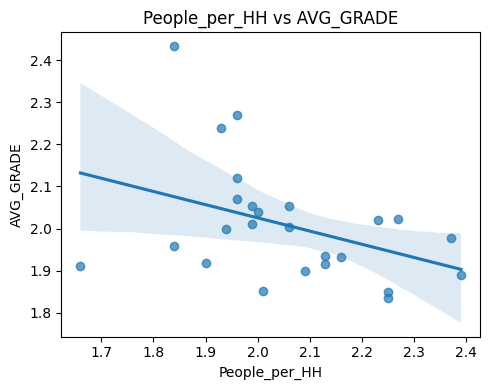

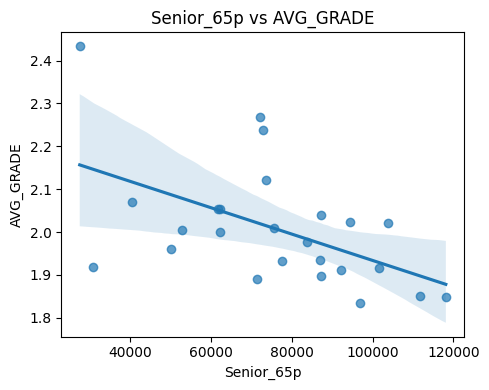

In [ ]:
key_features = ["Households", "Total_Pop", "Foreigners", "People_per_HH", "Senior_65p"]

for col in key_features:
    plt.figure(figsize=(5, 4))
    sns.regplot(data=df, x=col, y="AVG_GRADE", scatter_kws={"alpha": 0.7})
    plt.xlabel(col)
    plt.ylabel("AVG_GRADE")
    plt.title(f"{col} vs AVG_GRADE")
    plt.tight_layout()
    plt.show()

고령자 수, 총인구, 세대수, 세대당 인구:
대체로 우하향 → 값이 클수록 위험등급이 낮음(음의 상관)

외국인 수: 우상향에 가까운 패턴 → 값이 클수록 위험등급이 높음(양의 상관)

# 1-5. 상관계수 기준으로 중요한 변수 뽑기 (abs, 정렬)

AVG_GRADE와 가장 관련이 큰 변수 순서대로 정렬된 리스트 생성
기준 : 0.3 이상

In [ ]:
# AVG_GRADE와의 상관계수 절대값이 큰 순서대로 정렬
abs_corr = target_corr.abs().sort_values(ascending=False)

print("\n=== AVG_GRADE와 |상관계수|가 큰 순서 ===")
print(abs_corr)

threshold = 0.3
selected_features = abs_corr[abs_corr >= threshold].index.tolist()
print(f"\n|corr| >= {threshold} 인 변수들:", selected_features)


=== AVG_GRADE와 |상관계수|가 큰 순서 ===
Senior_65p       0.519455
Total_Pop        0.509989
Households       0.478313
People_per_HH    0.390769
Foreigners       0.313080
Name: AVG_GRADE, dtype: float64

|corr| >= 0.3 인 변수들: ['Senior_65p', 'Total_Pop', 'Households', 'People_per_HH', 'Foreigners']


# 1-6. info() / describe()로 분포 확인

변수들의 기본 정보(info)와 기술통계(describe)를 출력

---

info() -> 핵심 정보:

- 컬럼 이름
- 데이터 개수(Non-null)
- 누락값 여부
- 데이터 타입(int/float 등)
- 메모리 사용량

---
describe() -> 기술통계(Descriptive Statistics)

- count (데이터 개수)
- mean (평균)
- std (표준편차 → 데이터 분산 정도)
- min (최소값)
- max (최대값)
- 25%, 50%, 75% (분위수 → 데이터 분포 파악)



In [ ]:
num_cols = ["Households", "Total_Pop", "Foreigners", "People_per_HH", "Senior_65p", "AVG_GRADE"]

print("=== info ===")
print(df[num_cols].info())

print("\n=== describe ===")
display(df[num_cols].describe())

=== info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Households     25 non-null     int64  
 1   Total_Pop      25 non-null     int64  
 2   Foreigners     25 non-null     int64  
 3   People_per_HH  25 non-null     float64
 4   Senior_65p     25 non-null     int64  
 5   AVG_GRADE      25 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 1.3 KB
None

=== describe ===


,Households,Total_Pop,Foreigners,People_per_HH,Senior_65p,AVG_GRADE
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,180214.280000,383773.160000,11033.160000,2.054800,75769.800000,2.008133
std,58540.263414,127101.551529,6447.937821,0.174383,23695.525627,0.140133
min,64259.000000,128942.000000,2950.000000,1.660000,27442.000000,1.834951
25%,142545.000000,303770.000000,6058.000000,1.960000,62082.000000,1.915441
50%,180703.000000,385786.000000,10484.000000,2.010000,75563.000000,2.000000
75%,215129.000000,461842.000000,14244.000000,2.160000,92116.000000,2.052632
max,288964.000000,652094.000000,24485.000000,2.390000,118155.000000,2.433566


# 1-7. 히스토그램(분포 확인)

각 변수(세대수·총인구·외국인·세대당 인구·고령자·위험도)가 어떤 분포를 가지고 있는지 시각적으로 확인

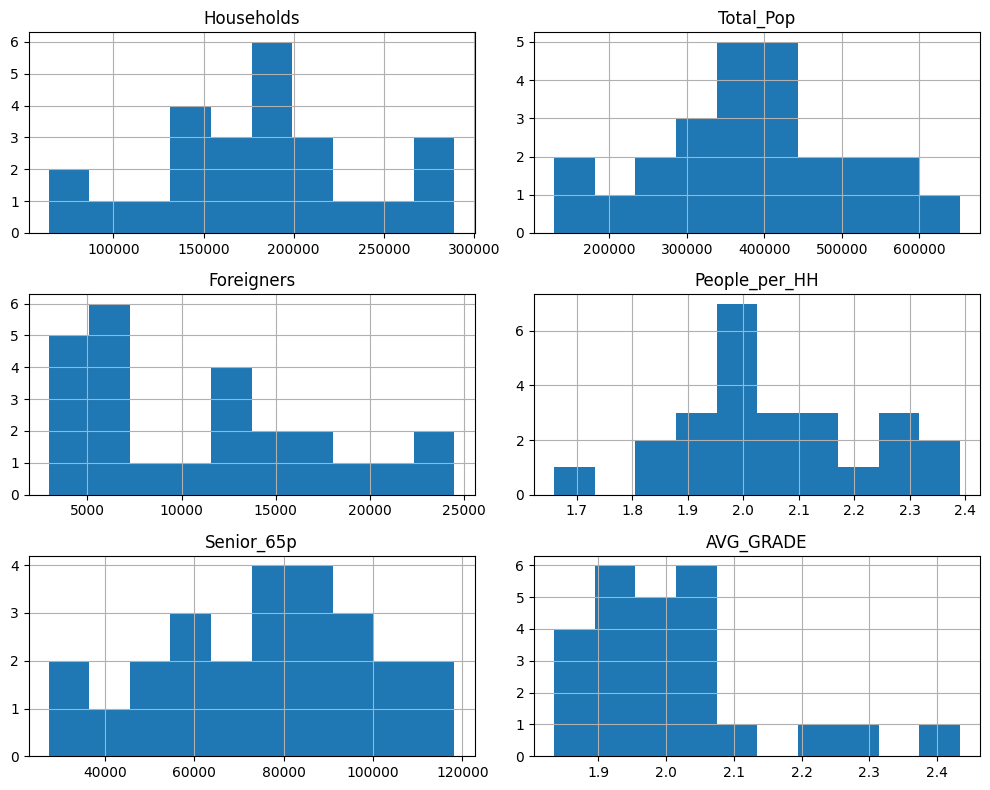

In [ ]:
df[num_cols].hist(figsize=(10, 8), bins=10)
plt.tight_layout()
plt.show()

세대수(Households): 구별로 편차가 큼

총인구(Total_Pop): 대부분 30~45만 명대에 몰려 있고 일부 구만 큼

외국인 수(Foreigners): 특정 몇 개구만 높고 나머지는 매우 낮음.

세대당 인구(People_per_HH): 거의 모든 구가 비슷

고령자 수(Senior_65p): 구마다 차이는 있으나 중간~상위 구간에 몰림

AVG_GRADE(위험도): 분산이 크지 않고 몇 구만 튐

# 1-8. Z-score 표준화(직접 계산 + StandardScaler 비교)

 Z-score 표준화(standardization) 를 두 가지 방식으로 수행하고,
그 결과를 df_z 데이터프레임에 컬럼으로 추가

- (A) 직접 평균·표준편차로 계산하는 수식 기반 z-score

- (B) sklearn의 StandardScaler 사용

결과를 비교해서 정확히 일치하는지 검증

In [ ]:
from sklearn.preprocessing import StandardScaler

# 복사본 생성
df_z = df.copy()

# (A) 직접 z-score 계산
for col in num_cols:
    if col == "AVG_GRADE":
        continue
    mean = df_z[col].mean()
    std = df_z[col].std(ddof=0)  # 모표준편차
    df_z[col + "_z_manual"] = (df_z[col] - mean) / std

# (B) sklearn StandardScaler로도 해보기
scaler = StandardScaler()
scaled = scaler.fit_transform(df[num_cols[:-1]])  # AVG_GRADE 제외하고 스케일링

for i, col in enumerate(num_cols[:-1]):
    df_z[col + "_z_skl"] = scaled[:, i]

print(df_z.head())

    GU  Households  Total_Pop  Foreigners  People_per_HH  Senior_65p  \
0  종로구       72402     149165       11620           1.90       30658   
1   중구       64259     128942       10484           1.84       27442   
2  용산구      103187     215716       13080           1.96       40342   
3  성동구      132994     282288        8093           2.06       52896   
4  광진구      171265     349963       17891           1.94       62240   

   AVG_GRADE  Households_z_manual  Total_Pop_z_manual  Foreigners_z_manual  \
0   1.918103            -1.879654           -1.883895             0.092889   
1   2.433566            -2.021623           -2.046285            -0.086925   
2   2.070175            -1.342933           -1.349493             0.323987   
3   2.004695            -0.823262           -0.814922            -0.465387   
4   2.000000            -0.156026           -0.271494             1.085503   

   People_per_HH_z_manual  Senior_65p_z_manual  Households_z_skl  \
0               -0.906008     

# 1-9. 단순 선형회귀 분석

예측값(y_pred) 과 실제값(y_true) 을 비교해서
**MAE, MSE, RMSE, R** 같은 대표적인 회귀 성능 지표들을 계산

머신러닝 모델(특히 회귀 모델)을 평가할 때 가장 기본이 되는 지표들을 한 번에 계산해 주도록 만든 함수

- MAE (평균 절대 오차)

- MSE (평균 제곱 오차)

- RMSE (평균 제곱근 오차)

- R² (결정계수)

In [ ]:
import numpy as np

def regression_metrics(y_true, y_pred):
    """
    MAE, MSE, RMSE, R^2 계산
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    assert y_true.shape == y_pred.shape

    errors = y_true - y_pred

    mae = np.mean(np.abs(errors))
    mse = np.mean(errors ** 2)
    rmse = np.sqrt(mse)

    sst = np.sum((y_true - y_true.mean()) ** 2)  # 총 변동
    ssr = np.sum((y_true - y_pred) ** 2)         # 잔차 제곱합
    r2 = 1 - ssr / sst

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}


각 변수를 하나만을 사용해 AVG_GRADE(평균 위험도)를 예측하는 단순 선형회귀 모델 LinearRegression()을 4개 만들어서 성능을 비교

- 각 지표가 단독으로 위험도를 얼마나 설명할 수 있는지
- 계수(coef)가 양/음인지 → 위험도에 미치는 영향 방향이 어떤지
- MAE·RMSE·R² → 예측력이 어느 정도인지

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

target = "AVG_GRADE"

simple_features = ["Total_Pop", "Senior_65p", "Foreigners", "People_per_HH"]

results_simple = {}

for feat in simple_features:
    X = df[[feat]].values
    y = df[target].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    metrics = regression_metrics(y_test, y_pred)

    results_simple[feat] = {
        "coef": float(model.coef_[0]),
        "intercept": float(model.intercept_),
        **metrics,
    }

print("=== 단순 선형회귀 결과 (각 feature 하나씩) ===")
for feat, res in results_simple.items():
    print(f"\n[{feat} -> AVG_GRADE]")
    print(f"  회귀식: y = {res['intercept']:.4f} + {res['coef']:.6f} * x")
    print(f"  MAE  = {res['MAE']:.4f}")
    print(f"  MSE  = {res['MSE']:.4f}")
    print(f"  RMSE = {res['RMSE']:.4f}")
    print(f"  R2   = {res['R2']:.4f}")

=== 단순 선형회귀 결과 (각 feature 하나씩) ===

[Total_Pop -> AVG_GRADE]
  회귀식: y = 2.2979 + -0.000001 * x
  MAE  = 0.0953
  MSE  = 0.0180
  RMSE = 0.1340
  R2   = -1.0535

[Senior_65p -> AVG_GRADE]
  회귀식: y = 2.3141 + -0.000004 * x
  MAE  = 0.0906
  MSE  = 0.0182
  RMSE = 0.1348
  R2   = -1.0788

[Foreigners -> AVG_GRADE]
  회귀식: y = 1.9120 + 0.000010 * x
  MAE  = 0.1373
  MSE  = 0.0240
  RMSE = 0.1548
  R2   = -1.7410

[People_per_HH -> AVG_GRADE]
  회귀식: y = 2.6219 + -0.290841 * x
  MAE  = 0.1083
  MSE  = 0.0125
  RMSE = 0.1119
  R2   = -0.4325


네 변수 모두 평균 위험도(AVG_GRADE)의 변동을 설명하는 데 한계가 있음

R²값이 음수로 -> 단독 변수만으로는 예측 성능이 충분하지 않음


BUT

- 세대당 인구(People_per_HH)는 다른 변수 대비 상대적으로 높은 설명력을 보여 위험도와의 관계성이 가장 뚜렷하게 나타났다.
- 외국인 수(Foreigners)는 양의 상관 방향은 확인되었으나 예측 성능은 가장 낮았다.

# 1-10. 다중 선형회귀 분석

4개의 변수(“Total_Pop, Senior_65p, Foreigners, People_per_HH
) 를 동시에 입력하여 **다중 선형회귀(Multiple Linear Regression) 를 수행**.

“단일 변수는 설명력이 약했는데, 여러 변수를 함께 쓰면 위험도 예측력이 개선되는가?”

In [ ]:
# 상관계수에서 의미 있어 보인 변수
multi_features = ["Total_Pop", "Senior_65p", "Foreigners", "People_per_HH"]

X = df[multi_features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

y_pred = multi_model.predict(X_test)
metrics_multi = regression_metrics(y_test, y_pred)

print("=== 다중 선형회귀 결과 ===")
print("사용한 feature:", multi_features)
print("계수 (coef_):", multi_model.coef_)
print("절편 (intercept_):", multi_model.intercept_)
for k, v in metrics_multi.items():
    print(f"{k}: {v:.4f}")

=== 다중 선형회귀 결과 ===
사용한 feature: ['Total_Pop', 'Senior_65p', 'Foreigners', 'People_per_HH']
계수 (coef_): [-5.37517436e-07 -6.82538268e-07  8.96864499e-06  7.81774218e-02]
절편 (intercept_): 2.020763082792912
MAE: 0.1208
MSE: 0.0249
RMSE: 0.1579
R2: -1.8520


 R²는 -1.85로 나타나 예측력이 매우 낮음

 ->AVG_GRADE의 분산이 작고, 독립변수들 간 다중공선성이 높아 선형 모델이 패턴을 학습하기 어렵기 때문으로 해석된다.

 단일 회귀보다도 성능이 낮음

-> 다중 선형회귀는 위험도 예측 모델로 적합하지 않은 것으로 판단

***"인구 구조만으로 평균 위험도를 선형적으로 예측하는 것은 어렵다"***

다중 선형회귀 모델의 계수를 정리한 표(DataFrame) 생성

In [ ]:
coef_df = pd.DataFrame({
    "feature": multi_features,
    "coef": multi_model.coef_
}).sort_values("coef", ascending=False)

print("\n=== 다중 회귀 계수 (feature 영향 방향/크기) ===")
display(coef_df)


=== 다중 회귀 계수 (feature 영향 방향/크기) ===


,feature,coef
3,People_per_HH,7.817742e-02
2,Foreigners,8.968645e-06
0,Total_Pop,-5.375174e-07
1,Senior_65p,-6.825383e-07


coef_df의 핵심

✔ 모델의 예측력이 낮기 때문에 계수 해석은 조심해야 함
(특히 People_per_HH의 방향이 뒤집힌 것은 대표적인 신호)

✔ 회귀 방향 자체는 상관계수와 대체로 일치

외국인 → 위험도 증가
총인구/고령자 → 위험도 감소

✔ 계수 크기는 변수 단위(scale)에 영향을 받음

Foreigners는 단위가 몇천 → coef가 아주 작게 나타남

People_per_HH는 단위 1.x → coef가 상대적으로 크게 나타남
→ 표준화(z-score) 회귀를 해야 영향력 비교가 정확해짐

# 1-11. 비율 변수(Senior_ratio, Foreigners_ratio) 추가 및 위험도 그룹화

구(pop) 데이터(df_pop) 에서
**고령자 비율, 외국인 비율**이라는 두 가지 비율형 변수(new features) 를 추가로 생성

단순히 절대 수(고령자 수, 외국인 수)만 보는 대신

**총인구 대비 비율로 변환**해 **위험도와의 관계를 더 명확하게 분석**하려는 목적

In [ ]:
df = df_pop.copy()

# 비율 변수 생성
df["Senior_ratio"] = df["Senior_65p"] / df["Total_Pop"]          # 고령자 비율
df["Foreigners_ratio"] = df["Foreigners"] / df["Total_Pop"]      # 외국인 비율

display(df[["GU", "Total_Pop", "Senior_ratio", "Foreigners_ratio", "AVG_GRADE"]].head())

,GU,Total_Pop,Senior_ratio,Foreigners_ratio,AVG_GRADE
0,종로구,149165,0.205531,0.077900,1.918103
1,중구,128942,0.212824,0.081308,2.433566
2,용산구,215716,0.187014,0.060635,2.070175
3,성동구,282288,0.187383,0.028669,2.004695
4,광진구,349963,0.177847,0.051123,2.000000


AVG_GRADE(평균 위험도) 값을 기준으로 3개의 분위수 그룹(tertiles)
Low / Mid / High 위험도 그룹 으로 자동 분류 _ qcut()

In [ ]:
# AVG_GRADE를 기준으로 분위수(tertile) 나누기
df["Risk_Group"] = pd.qcut(
    df["AVG_GRADE"],
    3,
    labels=["Low", "Mid", "High"]
)

df[["GU", "AVG_GRADE", "Risk_Group"]].sort_values("AVG_GRADE").head(25)



,GU,AVG_GRADE,Risk_Group
24,강동구,1.834951,Low
23,송파구,1.848624,Low
15,강서구,1.850667,Low
21,서초구,1.889435,Low
16,구로구,1.898438,Low
20,관악구,1.911290,Low
11,은평구,1.915441,Low
0,종로구,1.918103,Low
9,도봉구,1.931818,Low
7,성북구,1.933824,Mid


갯수 확인

In [ ]:
print(df["Risk_Group"].value_counts())

Risk_Group
Low     9
Mid     8
High    8
Name: count, dtype: int64


Risk_Group(위험도 그룹: Low / Mid / High) 별로 총인구 평균(mean_pop), 고령자 비율 평균(mean_senior_ratio), 외국인 비율 평균(mean_foreign_ratio)을 계산해서 한 표로 정리

In [ ]:
group_stats = (
    df
    .groupby("Risk_Group")
    .agg(
        mean_pop=("Total_Pop", "mean"),
        mean_senior_ratio=("Senior_ratio", "mean"),
        mean_foreign_ratio=("Foreigners_ratio", "mean")
    )
    .reset_index()
)

print(group_stats)

  Risk_Group       mean_pop  mean_senior_ratio  mean_foreign_ratio
0        Low  439225.333333           0.202629            0.026443
1        Mid  397121.500000           0.193024            0.029126
2       High  308041.125000           0.203423            0.047791


/tmp/ipython-input-1041363084.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Risk_Group")


Risk_Group(Low / Mid / High) 별로

-  평균 인구(mean_pop)

- 평균 고령자 비율(mean_senior_ratio)

- 평균 외국인 비율(mean_foreign_ratio)

을 막대그래프(barplot) 로 시각화

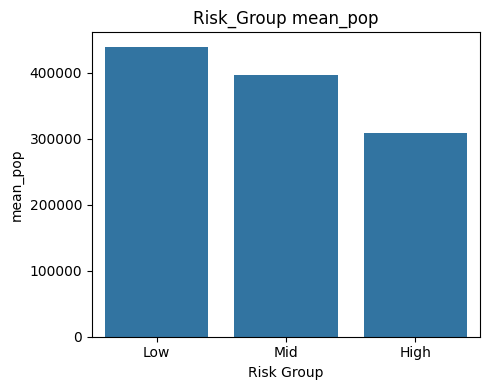

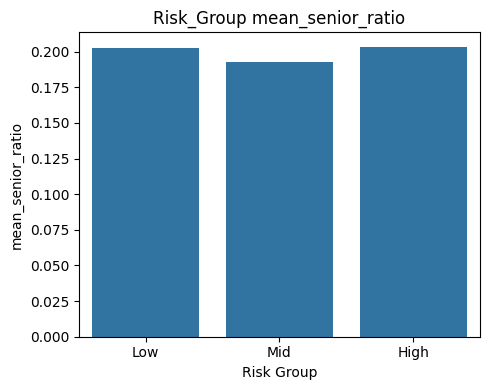

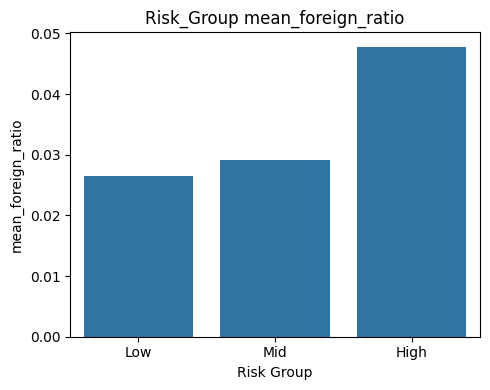

In [ ]:
# 1) 그룹별 평균 인구
plt.figure(figsize=(5, 4))
sns.barplot(data=group_stats, x="Risk_Group", y="mean_pop")
plt.title("Risk_Group mean_pop")
plt.xlabel("Risk Group")
plt.ylabel("mean_pop")
plt.tight_layout()
plt.show()

# 2) 그룹별 평균 고령자 비율
plt.figure(figsize=(5, 4))
sns.barplot(data=group_stats, x="Risk_Group", y="mean_senior_ratio")
plt.title("Risk_Group mean_senior_ratio")
plt.xlabel("Risk Group")
plt.ylabel("mean_senior_ratio")
plt.tight_layout()
plt.show()

# 3) 그룹별 평균 외국인 비율
plt.figure(figsize=(5, 4))
sns.barplot(data=group_stats, x="Risk_Group", y="mean_foreign_ratio")
plt.title("Risk_Group mean_foreign_ratio")
plt.xlabel("Risk Group")
plt.ylabel("mean_foreign_ratio")
plt.tight_layout()
plt.show()

High 위험 그룹 → 외국인 비율·유동성 높음

Low 위험 그룹 → 고령자 비율·주거 안정성 높음

**즉, 위험도는 단순 인구 크기보다는 인구 구성과 유동성에 더 민감함**

# 2. 치안 인프라(지구대·파출소) 분석

# 2-1. 데이터 로딩 및 전처리

구 인구 + 위험도 데이터(df_pop)

구별 소방서(또는 관서) 위험등급 데이터(df_sub)

→ 두 개의 데이터를 불러오고
→ 분석 전 데이터 구조를 점검



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



pop_path = "gu_population_with_risk.csv"
sub_path = "gu_substations_with_grade.csv"

df_pop = pd.read_csv(pop_path, encoding="utf-8-sig")
df_sub = pd.read_csv(sub_path, encoding="utf-8-sig")

print(df_pop.head())
print(df_sub.head())

    GU  Households  Total_Pop  Foreigners  People_per_HH  Senior_65p  \
0  종로구       72402     149165       11620           1.90       30658   
1   중구       64259     128942       10484           1.84       27442   
2  용산구      103187     215716       13080           1.96       40342   
3  성동구      132994     282288        8093           2.06       52896   
4  광진구      171265     349963       17891           1.94       62240   

   AVG_GRADE  
0   1.918103  
1   2.433566  
2   2.070175  
3   2.004695  
4   2.000000  
    GU  Substations_Count  AVG_GRADE
0  강남구                 14   2.022587
1  강동구                  9   1.834951
2  강북구                  9   2.120482
3  강서구                 11   1.850667
4  관악구                  9   1.911290


# 2-2.인구·위험도 데이터(df)와 지구대+파출소 데이터(df_sub) 를 결합
해서**구별 치안 인프라 밀도(Substations_per_100k)** 를 계산

In [ ]:
# df_pop (인구+위험도) 와 df_sub (지구대+파출소) 병합
sub = df_sub.copy()
sub = sub.rename(columns={"Substations_Count": "Substations"})

full = pd.merge(df, sub[["GU", "Substations"]], on="GU", how="left")

# 인구 10만 명당 지구대+파출소 수 (치안 인프라 밀도)
full["Substations_per_100k"] = full["Substations"] / (full["Total_Pop"] / 100000)

display(full[["GU", "AVG_GRADE", "Total_Pop", "Senior_ratio", "Foreigners_ratio", "Substations", "Substations_per_100k"]].head())


,GU,AVG_GRADE,Total_Pop,Senior_ratio,Foreigners_ratio,Substations,Substations_per_100k
0,종로구,1.918103,149165,0.205531,0.077900,19,12.737572
1,중구,2.433566,128942,0.212824,0.081308,15,11.633137
2,용산구,2.070175,215716,0.187014,0.060635,7,3.245007
3,성동구,2.004695,282288,0.187383,0.028669,9,3.188233
4,광진구,2.000000,349963,0.177847,0.051123,10,2.857445


# 2-3. 히트맵 시각화

치안 인프라 변수를 추가한 상태에서 전체 상관계수 행렬(correlation matrix) 을 계산하고,**숫자 출력 + Heatmap 시각화**

=== 상관계수 (치안 인프라 포함) ===
                      Substations  Substations_per_100k  Total_Pop  \
Substations              1.000000              0.788998  -0.143525   
Substations_per_100k     0.788998              1.000000  -0.662392   
Total_Pop               -0.143525             -0.662392   1.000000   
Senior_ratio            -0.055921              0.147462  -0.323302   
Foreigners_ratio         0.319448              0.626828  -0.710964   
AVG_GRADE                0.202668              0.402662  -0.509989   

                      Senior_ratio  Foreigners_ratio  AVG_GRADE  
Substations              -0.055921          0.319448   0.202668  
Substations_per_100k      0.147462          0.626828   0.402662  
Total_Pop                -0.323302         -0.710964  -0.509989  
Senior_ratio              1.000000         -0.057046   0.085935  
Foreigners_ratio         -0.057046          1.000000   0.531862  
AVG_GRADE                 0.085935          0.531862   1.000000  


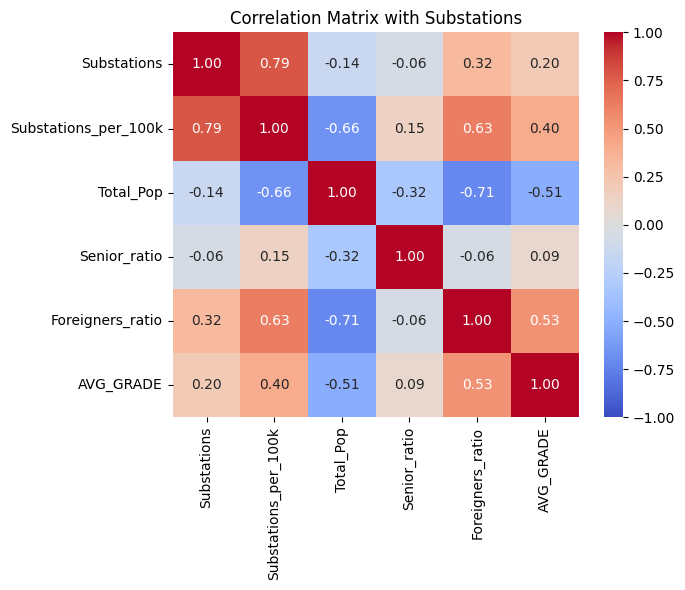

In [ ]:
cols_corr = ["Substations", "Substations_per_100k", "Total_Pop", "Senior_ratio", "Foreigners_ratio", "AVG_GRADE"]

corr2 = full[cols_corr].corr()
print("=== 상관계수 (치안 인프라 포함) ===")
print(corr2)

plt.figure(figsize=(7, 6))
sns.heatmap(corr2, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix with Substations")
plt.tight_layout()
plt.show()

**heatmap 기반 종합 결론**

외국인 비율 -> 가장 강력한 위험도 예측 변수

총인구 많은 지역 -> 위험도가 낮은 안정적 주거지역

치안 인프라 -> “위험도가 높은 지역에 더 많이 배치된 결과”

고령자 비율 -> 위험도와 거의 무상관

치안 인프라 vs 인구 구조는 완전히 다른 패턴

# 2-4. regplot 산점도 + 회귀선 그래프

치안 인프라(지구대+파출소) 와 위험도(AVG_GRADE) 사이의 관계를시각적으로 확인하기 위한 regplot 산점도 + 회귀선 그래프



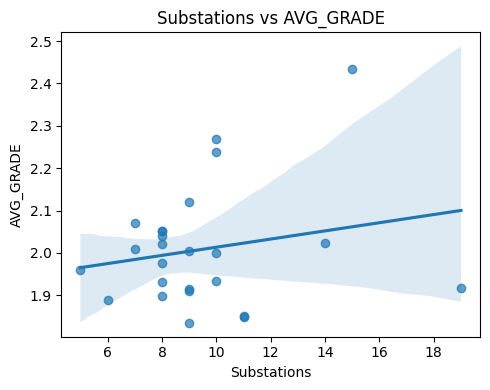

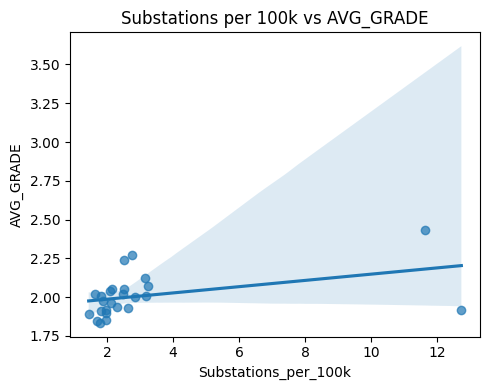

In [ ]:
# 1) 단순 개수 vs 위험도
plt.figure(figsize=(5, 4))
sns.regplot(data=full, x="Substations", y="AVG_GRADE", scatter_kws={"alpha": 0.7})
plt.xlabel("Substations")
plt.ylabel("AVG_GRADE")
plt.title("Substations vs AVG_GRADE")
plt.tight_layout()
plt.show()

# 2) 인구 10만 명당 지구대+파출소 수 vs 위험도
plt.figure(figsize=(5, 4))
sns.regplot(data=full, x="Substations_per_100k", y="AVG_GRADE", scatter_kws={"alpha": 0.7})
plt.xlabel("Substations_per_100k")
plt.ylabel("AVG_GRADE")
plt.title("Substations per 100k vs AVG_GRADE")
plt.tight_layout()
plt.show()

1. 치안 인프라 개수(Substations) → 위험도와 거의 관계 없음

→ 행정구역 특성(면적, 중심지 여부)의 영향.

✔ 2. 인구 대비 치안 밀도(Substations_per_100k) → 위험도와 양의 상관

→ 하지만 “위험도를 낮춘다”는 의미가 아니라
→ 위험지역에 치안인프라가 더 많이 배치된 결과.

✔ 3. 치안 인프라 자체는 위험도 변화의 원인이 아님

→ 외국인 비율, 총인구, 지역 활동 패턴 등 구조적 요인들이 더 강력.

#2-5.“위험도가 높은 구들 중에서도, 치안 인프라(지구대·파출소) 밀도가 특히 낮은 지역을 찾아내어 우선적으로 개입할 대상을 선정”


즉 고위험(High 위험도) + 저(低) 인프라 지역 = 가장 우선적으로 개선이 필요한 구
를 찾는 로직.

In [ ]:
# 1) 고위험 구만 뽑기
high = full[full["Risk_Group"] == "High"].copy()

# 2) 고위험 그룹 안에서 인구 대비 인프라 밀도 하위 1/3
threshold = high["Substations_per_100k"].quantile(1/3)
candidates = high[high["Substations_per_100k"] <= threshold].copy()

print("=== 우선 개입 후보 (고위험 + 인프라 밀도 낮은 구) ===")
display(candidates[["GU", "AVG_GRADE", "Total_Pop", "Senior_ratio", "Foreigners_ratio", "Substations", "Substations_per_100k"]])

=== 우선 개입 후보 (고위험 + 인프라 밀도 낮은 구) ===


,GU,AVG_GRADE,Total_Pop,Senior_ratio,Foreigners_ratio,Substations,Substations_per_100k
6,중랑구,2.039301,383737,0.227231,0.017293,8,2.084761
12,서대문구,2.052632,317826,0.195333,0.052633,8,2.517101
13,마포구,2.052632,370471,0.166496,0.031654,8,2.159413


# 2-6. 그룹별 시각화

Risk_Group(Low / Mid / High) 별로 평균 치안시설 개수(Substations), 평균 치안 밀도(Substations_per_100k)
를 시각화

  Risk_Group  mean_substations  mean_sub_per_100k
0        Low            10.000           3.107160
1        Mid             8.875           2.278217
2       High             9.375           3.755574


/tmp/ipython-input-4267544699.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Risk_Group")


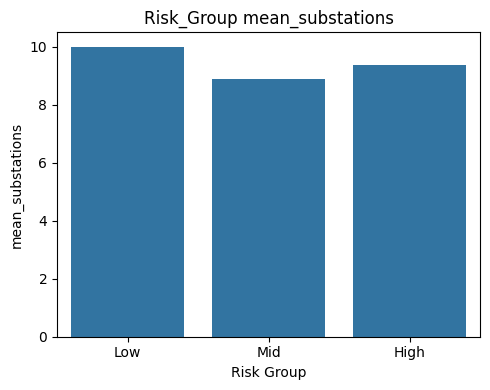

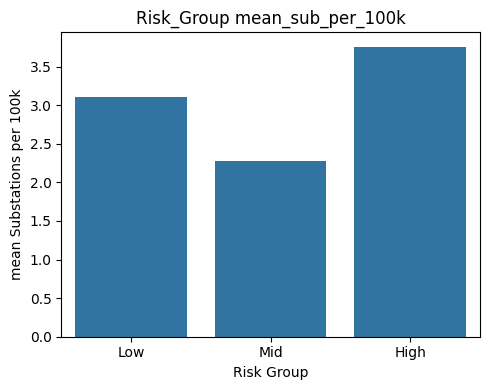

In [ ]:
group_stats_infra = (
    full
    .groupby("Risk_Group")
    .agg(
        mean_substations=("Substations", "mean"),
        mean_sub_per_100k=("Substations_per_100k", "mean")
    )
    .reset_index()
)

print(group_stats_infra)

# 1) 위험 그룹별 평균 지구대+파출소 개수
plt.figure(figsize=(5, 4))
sns.barplot(data=group_stats_infra, x="Risk_Group", y="mean_substations")
plt.title("Risk_Group mean_substations")
plt.xlabel("Risk Group")
plt.ylabel("mean_substations")
plt.tight_layout()
plt.show()

# 2) 위험 그룹별 인구 10만 명당 지구대+파출소 수
plt.figure(figsize=(5, 4))
sns.barplot(data=group_stats_infra, x="Risk_Group", y="mean_sub_per_100k")
plt.title("Risk_Group mean_sub_per_100k")
plt.xlabel("Risk Group")
plt.ylabel("mean Substations per 100k")
plt.tight_layout()
plt.show()

# 2-7. 상관관계분석 및 산점도+회귀선

구(자치구) 단위 평균 위험도와 여러 특성 사이의 상관관계를 분석하고,
또 **각 특성과 위험도(AVG_GRADE)의 관계를 산점도 + 회귀선(regression line)**으로 시각화하기 위한 분석용 함수 및 기본 데이터 읽기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 1) 구 단위 평균 위험도 읽기
risk_path = "구 단위 평균 위험도.csv"
df_risk = pd.read_csv(risk_path, encoding="utf-8-sig")

# 컬럼명 통일
df_risk = df_risk.rename(columns={"행정구역": "GU", "평균 위험도": "AVG_GRADE"})
display(df_risk.head())

# 2) 분석 보조 함수: 상관계수 + 산점도 찍어보기
def analyze_corr_and_scatter(df, feature_cols, target_col="AVG_GRADE", title_prefix=""):
    """
    df: GU 단위로 묶인 데이터 (feature + AVG_GRADE 포함)
    feature_cols: 비교할 특성 리스트
    """
    print("=== 상관계수 행렬 ===")
    print(df[feature_cols + [target_col]].corr())

    print("\n=== AVG_GRADE와의 상관계수 ===")
    target_corr = df[feature_cols + [target_col]].corr()[target_col].drop(target_col)
    print(target_corr.sort_values(ascending=False))

    # 산점도 + 회귀선
    for col in feature_cols:
        plt.figure(figsize=(5, 4))
        sns.regplot(data=df, x=col, y=target_col, scatter_kws={"alpha": 0.7})
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.title(f"{title_prefix} {col} vs {target_col}")
        plt.tight_layout()
        plt.show()

,GU,AVG_GRADE
0,강남구,2.022587
1,강동구,1.834951
2,강북구,2.120482
3,강서구,1.850667
4,관악구,1.911290


#3. 유동·주거·직장 인구 분석

서울시 행정구역별 유동·주거·직장 인구 데이터(2023–2025 2분기) 를 불러와서
데이터 구조를 확인

In [ ]:
pop_flow_path = "서울_행정구역별_유동주거직장인구_2023-2025_2분기.csv"

df_flow = pd.read_csv(pop_flow_path, encoding="utf-8-sig")  # 안 되면 cp949로 한번 더
print(df_flow.shape)
display(df_flow.head())
print(df_flow.columns)

(26, 10)


,행정구역,2023년2분기_집단내유동인구,2023년2분기_주거인구,2023년2분기_직장인구,2024년2분기_집단내유동인구,2024년2분기_주거인구,2024년2분기_직장인구,2025년2분기_집단내유동인구,2025년2분기_주거인구,2025년2분기_직장인구
0,서울시 전체,38664,155,61,38238,155,65,37681,155,69
1,종로구,28776,60,92,28462,58,90,28124,58,93
2,중구,60497,122,398,59302,121,437,57777,121,407
3,용산구,29131,100,68,27276,97,63,26694,97,80
4,성동구,43526,170,36,43880,165,46,43185,165,44


Index(['행정구역', '2023년2분기_집단내유동인구', '2023년2분기_주거인구', '2023년2분기_직장인구',
       '2024년2분기_집단내유동인구', '2024년2분기_주거인구', '2024년2분기_직장인구',
       '2025년2분기_집단내유동인구', '2025년2분기_주거인구', '2025년2분기_직장인구'],
      dtype='object')


유동·주거·직장 인구 데이터를 자치구 단위로 집계한 뒤,
구 단위 평균 위험도(df_risk) 와 병합

In [ ]:
GU_COL = "행정구역"             # 구 이름
FLOW_COL = "2025년2분기_집단내유동인구"     # 유동 인구 합계
RES_COL = "2025년2분기_주거인구"      # 주거 인구 합계
WORK_COL = "2025년2분기_직장인구"     # 직장 인구 합계

# 1) 구 단위 합계/평균 등으로 집계 (여기서는 합계 예시)
df_flow_gu = (
    df_flow
    .groupby(GU_COL)
    [[FLOW_COL, RES_COL, WORK_COL]]
    .sum()
    .reset_index()
)

df_flow_gu = df_flow_gu.rename(columns={
    GU_COL: "GU",
    FLOW_COL: "Flow_Pop",
    RES_COL: "Resident_Pop",
    WORK_COL: "Work_Pop",
})

print("구 단위 유동/주거/직장 인구:")
display(df_flow_gu.head())

# 2) 위험도와 merge
df_flow_merged = pd.merge(df_flow_gu, df_risk, on="GU", how="inner")
print(df_flow_merged.shape)
display(df_flow_merged.head())

구 단위 유동/주거/직장 인구:


,GU,Flow_Pop,Resident_Pop,Work_Pop
0,강남구,36113,137,273
1,강동구,43134,186,21
2,강북구,37928,122,6
3,강서구,27253,135,18
4,관악구,42418,162,14


(25, 5)


,GU,Flow_Pop,Resident_Pop,Work_Pop,AVG_GRADE
0,강남구,36113,137,273,2.022587
1,강동구,43134,186,21,1.834951
2,강북구,37928,122,6,2.120482
3,강서구,27253,135,18,1.850667
4,관악구,42418,162,14,1.911290


유동·주거·직장 인구(Flow/Resident/Work Pop) 와
구 단위 평균 위험도(AVG_GRADE) 사이의 관계를 분석

=== 상관계수 행렬 ===
              Flow_Pop  Resident_Pop  Work_Pop  AVG_GRADE
Flow_Pop      1.000000      0.597960  0.096447   0.581912
Resident_Pop  0.597960      1.000000 -0.292819  -0.004356
Work_Pop      0.096447     -0.292819  1.000000   0.545028
AVG_GRADE     0.581912     -0.004356  0.545028   1.000000

=== AVG_GRADE와의 상관계수 ===
Flow_Pop        0.581912
Work_Pop        0.545028
Resident_Pop   -0.004356
Name: AVG_GRADE, dtype: float64


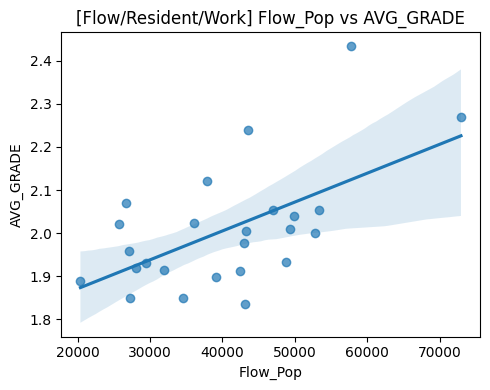

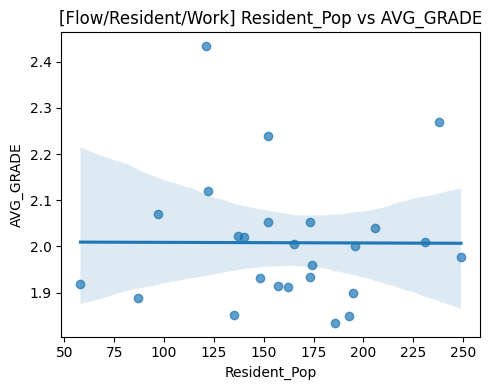

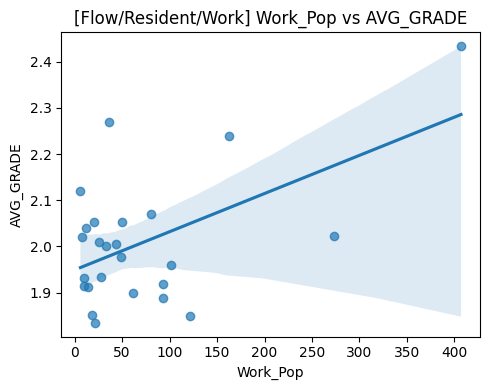

In [ ]:
feature_cols_flow = ["Flow_Pop", "Resident_Pop", "Work_Pop"]
analyze_corr_and_scatter(
    df_flow_merged,
    feature_cols=feature_cols_flow,
    target_col="AVG_GRADE",
    title_prefix="[Flow/Resident/Work]"
)

유동 인구(Flow_Pop) → 상관 0.58

직장 인구(Work_Pop) → 상관 0.55

주거 인구(Resident_Pop) → 상관 거의 없음

"사람이 모이고 이동하는 곳에서 사고 위험도가 높게 나타남

**즉, 정주 패턴보다는 도시 활동성이 사고 위험도를 더 설명하는 변수임**"

# 4. 공연시설 수 분석

공연시설 DB 엑셀 파일을 불러와 DataFrame 구조를 확인

In [ ]:
perf_path = "DB검색_공연시설DB.xlsx"

df_perf = pd.read_excel(perf_path, header = 2)
print(df_perf.shape)
display(df_perf.head())
print(df_perf.columns)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(1528, 11)


,총 검색 건수: 1526건 (2025.12.03 기준),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,No.,시설명,공연장수,총객석수,공연장명,객석수,시설특성,개관연도,지역,NaN,주소
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,시(도),구(군),NaN
2,1,1987 루프탑라운지 더 마에스트로점 [성수],1,0,1987 루프탑라운지 (4F),0,기타(비공연장),0000,서울,성동구,서울특별시 성동구 왕십리로 106 (성수동1가)
3,2,1M SPACE (폐관),1,55,1M SPACE (폐관),55,민간(대학로 외),2019,서울,서대문구,서울특별시 서대문구 연세로4길 27 (창천동)
4,3,1m클래식아트홀,1,130,1m클래식아트홀,130,민간(대학로 외),2008,서울,종로구,서울특별시 종로구 종로1길 50 (중학동)더케이트윈타워


Index(['총 검색 건수: 1526건 (2025.12.03 기준)', 'Unnamed: 1', 'Unnamed: 2',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'],
      dtype='object')


공연시설 DB에서 서울만 추려서, 자치구별 공연시설 개수를 집계

In [ ]:
SIDO_COL = "Unnamed: 8"
GU_COL = "Unnamed: 9"

# 1) 서울 공연시설만 필터링
df_perf_seoul = df_perf[df_perf[SIDO_COL] == "서울"].copy()

# 2) 구별 공연시설 개수
df_perf_gu = (
    df_perf_seoul
    .groupby(GU_COL)
    .size()
    .reset_index(name="Performance_Count")
)

df_perf_gu = df_perf_gu.rename(columns={GU_COL: "GU"})
print("구별 공연시설 개수:")
display(df_perf_gu.head())

구별 공연시설 개수:


,GU,Performance_Count
0,강남구,165
1,강동구,9
2,강북구,13
3,강서구,19
4,관악구,15


공연시설 개수와 구 단위 평균 위험도(AVG_GRADE) 사이의 관계를 분석

,GU,Performance_Count,AVG_GRADE
0,강남구,165,2.022587
1,강동구,9,1.834951
2,강북구,13,2.120482
3,강서구,19,1.850667
4,관악구,15,1.911290


=== 상관계수 행렬 ===
                   Performance_Count  AVG_GRADE
Performance_Count           1.000000   0.057372
AVG_GRADE                   0.057372   1.000000

=== AVG_GRADE와의 상관계수 ===
Performance_Count    0.057372
Name: AVG_GRADE, dtype: float64


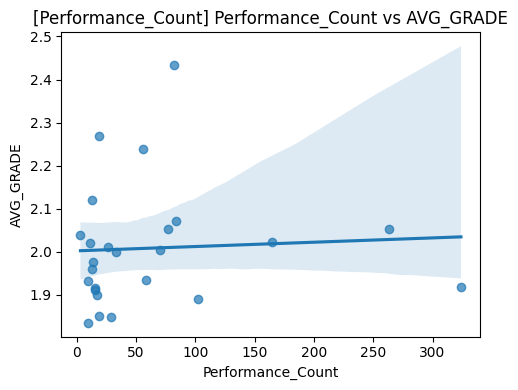

In [ ]:
df_perf_merged = pd.merge(df_perf_gu, df_risk, on="GU", how="inner")
display(df_perf_merged.head())

feature_cols_perf = ["Performance_Count"]

analyze_corr_and_scatter(
    df_perf_merged,
    feature_cols=feature_cols_perf,
    target_col="AVG_GRADE",
    title_prefix="[Performance_Count]"
)

공연시설 수와 평균 위험도 간 상관계수는 0.057로 거의 0에 가까움

 -> **공연 인프라와 위험도는 의미 있는 선형적 관계가 없음**

 ---

# 5. 불법주정차 신고 데이터 분석

불법주정차 신고 현황 CSV 파일을 불러오고, 데이터 구조를 확인

In [ ]:
import pandas as pd

illegal_path = "불법주정차 신고현황(23년11월1일_24년3월13일).csv"

df = pd.read_csv(illegal_path, encoding="utf-8-sig")
print(df.shape)
display(df.head())
print(df.columns)

(493658, 5)


,민원접수일,민원접수시간,주소,경도,위도
0,20231101,00:00:00,서울특별시 성동구 사근동길 45,127.045952,37.560972
1,20231101,00:03:00,구로구 가마산로12길 18 앞쪽 고가차도 밑,126.882717,37.492723
2,20231101,00:04:00,공/남부순환로11길 55,126.814655,37.555981
3,20231101,00:07:00,아차산로57길 4 CU구의중앙점 앞,127.088326,37.538708
4,20231101,00:09:00,방학동717-2 [ 도봉로150다길 28] ~ 방학동717-3 주차장 입구 및 전체...,127.044821,37.667286


Index(['민원접수일', '민원접수시간', '주소', '경도', '위도'], dtype='object')


지리정보(Geospatial) 데이터 분석을 위해 필요한 파이썬 패키지를 설치하는 명령어

In [ ]:
!pip install geopandas shapely pyproj rtree -q

GeoPandas로 서울시 자치구 경계 데이터를 불러오고, 어떤 컬럼을 갖고 있는지 확인

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# 서울 자치구 경계 GeoJSON (구 단위)
seoul_gu_url = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"

gu_gdf = gpd.read_file(seoul_gu_url)
print(gu_gdf.columns)
gu_gdf[["name"]].head()

Index(['code', 'name', 'name_eng', 'base_year', 'geometry'], dtype='object')


,name
0,강동구
1,송파구
2,강남구
3,서초구
4,관악구


In [ ]:
LAT_COL = "위도"
LON_COL = "경도"
ADDR_COL = "주소"



불법주정차 신고 좌표(Point)를 서울 자치구 Polygon과 공간 조인하여, 좌표가 어느 자치구에 속하는지 자동으로 매칭


-> 신고 데이터에 “실제 위치 기반 자치구(GU)”를 붙여주는 작업

In [ ]:
# 1) 포인트 GeoDataFrame으로 변환
points_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df[LON_COL], df[LAT_COL]),
    crs="EPSG:4326"
)

# 2) 구 경계에서 필요한 컬럼만 선택
gu_for_join = gu_gdf[["name", "geometry"]].copy()

# 3) 공간조인: 포인트가 속한 구 polygon 찾기
joined = gpd.sjoin(
    points_gdf,
    gu_for_join,
    how="left",
    predicate="within"
)

# 4) 'name' 컬럼을 GU로 이름 변경
joined = joined.rename(columns={"name": "GU_from_coord"})

# 결과 확인
joined[[ADDR_COL, LAT_COL, LON_COL, "GU_from_coord"]].head()

,주소,위도,경도,GU_from_coord
0,서울특별시 성동구 사근동길 45,37.560972,127.045952,성동구
1,구로구 가마산로12길 18 앞쪽 고가차도 밑,37.492723,126.882717,구로구
2,공/남부순환로11길 55,37.555981,126.814655,강서구
3,아차산로57길 4 CU구의중앙점 앞,37.538708,127.088326,광진구
4,방학동717-2 [ 도봉로150다길 28] ~ 방학동717-3 주차장 입구 및 전체...,37.667286,127.044821,도봉구


In [ ]:
joined["자치구_좌표기준"] = joined["GU_from_coord"]



공간조인 결과(joined DataFrame)를 CSV로 저장


공간 분석에 사용된 geometry 등 불필요한 컬럼을 제거하고 정리된 형태로 저장

In [ ]:
out_path = "불법주정차_구추가_주소수정.csv"
joined.drop(columns=["geometry", "index_right"], errors="ignore").to_csv(
    out_path, index=False, encoding="utf-8-sig"
)
print("저장 완료:", out_path)

저장 완료: 불법주정차_구추가_주소수정.csv


공간조인 후 저장해둔 ‘불법주정차_구추가_주소수정.csv’ 파일을 다시 불러와 확인

In [ ]:
illegal_path = "불법주정차_구추가_주소수정.csv"

df_illegal = pd.read_csv(illegal_path, encoding="utf-8-sig")
print(df_illegal.shape)
display(df_illegal.head())
print(df_illegal.columns)

(493658, 8)


,민원접수일,민원접수시간,주소,경도,위도,GU_from_coord,자치구_좌표기준,주소_구수정
0,20231101,00:00:00,서울특별시 성동구 사근동길 45,127.045952,37.560972,성동구,성동구,서울특별시 성동구 사근동길 45
1,20231101,00:03:00,구로구 가마산로12길 18 앞쪽 고가차도 밑,126.882717,37.492723,구로구,구로구,구로구 가마산로12길 18 앞쪽 고가차도 밑
2,20231101,00:04:00,공/남부순환로11길 55,126.814655,37.555981,강서구,강서구,공/남부순환로11길 55
3,20231101,00:07:00,아차산로57길 4 CU구의중앙점 앞,127.088326,37.538708,광진구,광진구,아차산로57길 4 CU구의중앙점 앞
4,20231101,00:09:00,방학동717-2 [ 도봉로150다길 28] ~ 방학동717-3 주차장 입구 및 전체...,127.044821,37.667286,도봉구,도봉구,방학동717-2 [ 도봉로150다길 28] ~ 방학동717-3 주차장 입구 및 전체...


Index(['민원접수일', '민원접수시간', '주소', '경도', '위도', 'GU_from_coord', '자치구_좌표기준',
       '주소_구수정'],
      dtype='object')


불법주정차 신고 데이터에 구(GU) 정보를 정리하고, 구별로 신고 건수를 집계

In [ ]:

if "GU" not in df_illegal.columns:
    GU_COL = "GU_from_coord"
    df_illegal = df_illegal.rename(columns={GU_COL: "GU"})

# 1) 단순 건수 집계
df_illegal_gu = (
    df_illegal
    .groupby("GU")
    .size()
    .reset_index(name="Illegal_Parking_Reports")
)

print("구별 불법주정차 신고 건수:")
display(df_illegal_gu.head())

구별 불법주정차 신고 건수:


,GU,Illegal_Parking_Reports
0,강남구,54906
1,강동구,20031
2,강북구,9878
3,강서구,44144
4,관악구,23694


불법주정차 신고 건수와 평균 위험도(AVG_GRADE)의 관계를 분석

,GU,Illegal_Parking_Reports,AVG_GRADE
0,강남구,54906,2.022587
1,강동구,20031,1.834951
2,강북구,9878,2.120482
3,강서구,44144,1.850667
4,관악구,23694,1.911290


=== 상관계수 행렬 ===
                         Illegal_Parking_Reports  AVG_GRADE
Illegal_Parking_Reports                 1.000000  -0.132979
AVG_GRADE                              -0.132979   1.000000

=== AVG_GRADE와의 상관계수 ===
Illegal_Parking_Reports   -0.132979
Name: AVG_GRADE, dtype: float64


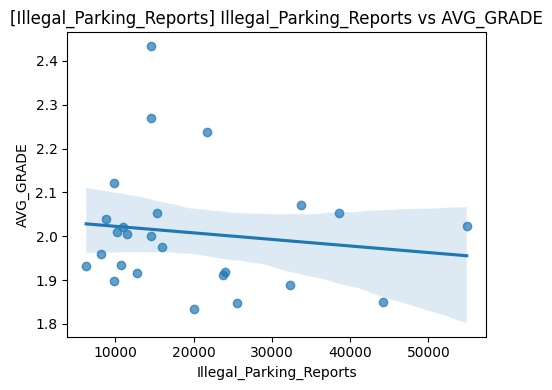

In [ ]:
df_illegal_merged = pd.merge(df_illegal_gu, df_risk, on="GU", how="inner")
display(df_illegal_merged.head())

feature_cols_illegal = ["Illegal_Parking_Reports"]

analyze_corr_and_scatter(
    df_illegal_merged,
    feature_cols=feature_cols_illegal,
    target_col="AVG_GRADE",
    title_prefix="[Illegal_Parking_Reports]"
)

불법주정차 신고 건수가 많다고 해서 위험도가 높아지는 것이 아님

조금 감소하는 경향이 있긴 하지만,거의 의미 없는 수준

# 개선모델

**안전 인프라 관련 Feature**

cctv_count — 안심이 CCTV 개수

cctv2_count — 일반 CCTV 개수

fire_count — 소방시설 개수

police_count — 경찰·치안시설 개수

bell_count — 비상벨 설치 개수

child_guard_count — 어린이 보호구역 개수

**사회/환경 위험 요인 Feature**

population — 해당 격자의 인구 수

crime_count — 해당 격자의 범죄 건수

---


**사용 모델 = LIGHTBGM**

**LightGBM**
Gradient Boosting 기반 머신러닝 알고리즘

Decision Tree를 기반으로 하여 여러 약한 모델을 순차적으로 학습시키는 방식으로 강력한 예측 모델을 생성

**주요 특징**

**Histogram 기반 학습 방식 사용**

->연속형 데이터를 구간(bin)으로 나누어 계산량을 크게 줄임.

->메모리 사용량과 학습 시간이 크게 절감

**Leaf-wise(Tree-leaf) 성장 전략 적용**

->손실 감소량이 가장 큰 리프 노드부터 확장하는 방식
->기존 Level-wise 방식보다 빠르게 손실을 줄일 수 있어 성능이 우수

**대규모 데이터 처리에 최적화됨**

->수십만~수백만 개의 샘플을 처리하는 데 효율적인 구조를 가짐.

->병렬 처리 및 GPU 학습을 지원하여 계산 속도를 크게 향상시킴.

**내장된 Class weight 지원**

->데이터 불균형 상황에서 소수 클래스의 가중치를 자동 조정하여 학습을 안정화

(본 프로젝트에서는 class_weight='balanced' 옵션을 사용함.)

---



WHY?

- 격자 단위(약 1만 개) 데이터에 대해 빠르고 효율적인 학습 필요

- CCTV, 소방·치안 인프라 등 다양한 스케일의 피처를 안정적으로 처리 가능함

- 위험 등급처럼 다중 클래스 분류 문제에 강한 성능을 보임

- 불균형 데이터에 대응하기 위해 class_weight='balanced' 옵션 활용이 용이함

---



HOW?

- 8개의 안전 인프라 관련 피처를 입력값으로 사용함

- risk_grade(1~10등급)를 다중 클래스 분류 형태로 예측함

- Min–Max Scaling을 적용하여 값의 편차를 조정함

- LightGBM 분류 모델로 전체 격자의 예측 등급을 산출함

- Feature importance 분석을 통해 주요 영향을 주는 변수 확인함

---

전체 흐름

- 격자 위험도 데이터 전처리

- avg_risk → 10등급 위험도 분류

- LightGBM 기반 위험등급 예측 모델 구축

- Feature importance 분석

- 위험지역 예측(pred_grade) 생성

- CCTV 부족 & 고위험 지역을 결합한 우선 보강 지역 도출

- Folium 기반 서울 위험도 지도 시각화

- 최종 분석 테이블 저장

---

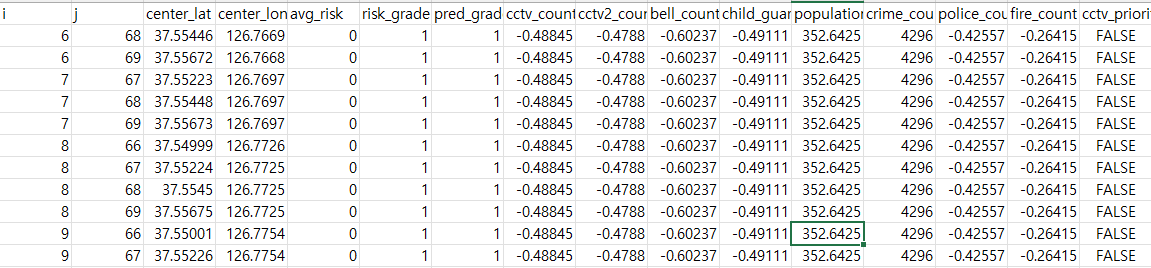

위 사진은 밑의 코드에 사용되는 grid_risk_grade_table.csv 파일의 일부이다.
i,j 는 격자의 번호, 격자의 한가운데 부분의 위도, 경도 좌표이다.


각각의 센서 인프라의 위치가 써져있는 8개의 csv파일의 각각의 위도,경도 데이터 좌표를 가져와 전처리하여 병합을 진행했고, 해당 격자의 CCTV 개수는 전체
격자의 평균보다 표준편차가 얼마만큼 작은지를 나타내는 상대값을 매핑했다.
이후 하나의 csv파일로 병합을 진행하였다.


병합한 csv 파일을 이용해 LightGBM 모델을 이용해 각각의 격자안에서 발생했던 범죄사고와 예측된 위험률을 비교하는 작업을 진행한다.




센서 인프라만의 데이터로는 얼마나 범죄가 일어날 수 있는가? 를 예측 할수는 없다.
하지만 각 격자단위로 등급을 매겨 어느 격자가 위험도가 높은지 순서를 정할수는 있고, 이 순서에 따른 위험도와 실제 데이터를 비교하여 예측 가능 할 수 있는데에 목적이 있다.

LightGBM 모델을 활용해 데이터를 학습하는 과정에있어서

샘플이 적은 등급일수록 더 큰 가중치를 주고,

샘플이 많은 등급일수록 작은 가중치를 줘서

학습 시 손실을 계산할 때 “희귀 등급을 틀리는 것”을 더 크게 벌점을 주게 된다.




loss = Σ (w_class * loss_i) 형태로 계산하고,

여기서  W가 클래스 불균형을 보정해 주는 weight 역할을 한다.

model = lgb.LGBMClassifier(class_weight='balanced')
model.fit(X_train_scaled_df, y_train)

“클래스 1등급~10등급별 가중치”만 자동으로 주는 구조이다.


model.fit(X_train_scaled_df, y_train)



1. 초기 예측값(예: 모든 샘플을 평균적인 등급으로 본다)을 설정한다.

2. 현재 예측과 정답(risk_grade) 사이의 손실(loss) 를 계산한다.
이때 각 샘플의 손실은 해당 등급의 가중치를 반영해서 계산된다.

3. 손실을 가장 많이 줄일 수 있는 분할을 찾으면서 결정트리(weak learner)를 하나 만든다.

4. 이 트리를 이전 예측 결과에 조금씩 더해가면서(gradient boosting)
점점 예측을 실제 라벨에 맞춰간다.

5. 이런 트리를 여러 개 쌓아서 앙상블을 만든후, 최종적으로 각 격자에 대해 1~10등급 중 하나를 예측하게 된다.

모든 결측치가 0으로 대체된 processed_risk_grid_seoul_only_filled.csv 저장 완료

[avg_risk 기준 위험등급 구간]
1등급: -0.0100 ~ 1.0000
2등급: 1.0000 ~ 2.0000
3등급: 2.0000 ~ 3.0000
4등급: 3.0000 ~ 4.0000
5등급: 4.0000 ~ 5.0000
6등급: 5.0000 ~ 6.0000
7등급: 6.0000 ~ 7.0000
8등급: 7.0000 ~ 8.0000
9등급: 8.0000 ~ 9.0000
10등급: 9.0000 ~ 10.0000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 7751, number of used features: 8
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training fro

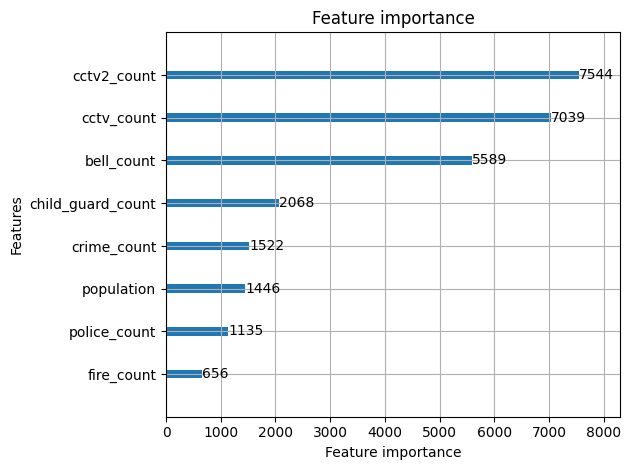


[모델 성능 평가]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-4252201176.py:151: MatplotlibD

              precision    recall  f1-score   support

           1       0.93      0.83      0.88      1745
           2       0.06      0.12      0.08        57
           3       0.01      0.02      0.02        42
           4       0.04      0.10      0.05        31
           5       0.05      0.08      0.06        25
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         1

    accuracy                           0.76      1938
   macro avg       0.11      0.12      0.11      1938
weighted avg       0.84      0.76      0.79      1938

Confusion Matrix:
[[1457  102   70   64   27   19    2    2    2    0]
 [  38    7    6    2    2    1    1    0    0    0]
 [  27    6    1    3    2    2    0    0    1    0]
 [  20    2    3    3    2    0    1    0    0    0]
 [  10    3

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors

## 1 - 3)=================================================================
##"grid_risk_grade_table.csv"를 불러오고
##분석에 필요한 컬럼만 선택한 뒤, 결측치를 처리

# 1. AI 분석에 사용할 데이터 불러오기
df = pd.read_csv('/content/grid_risk_grade_table.csv')

# 2. i, j + 좌표 + feature만 남기기
feature_cols = [
    'cctv_count',        # 안심이 CCTV
    'cctv2_count',       # 일반 CCTV
    'fire_count',        # 소방시설
    'police_count',      # 치안시설
    'bell_count',        # 비상벨
    'child_guard_count', # 아동안전지킴이집
    'population',        # 인구
    'crime_count'        # 범죄건수
]

cols = ['i', 'j', 'center_lat', 'center_lon'] + feature_cols + ['avg_risk']
df = df[cols]

# 3. 결측치 처리
for col in cols:
    df[col] = df[col].fillna(0)

df.to_csv('processed_risk_grid_seoul_only_filled.csv', index=False)
print("모든 결측치가 0으로 대체된 processed_risk_grid_seoul_only_filled.csv 저장 완료")


## 4 ) ==================================================================
## 4. 등급화 (10등급, avg_risk 기준 구간 나누기)
##“avg_risk는 연속형 값 -> equal-width binning으로 1~10등급의 분류 라벨로 변환

df['risk_grade'] = pd.cut(df['avg_risk'], bins=10, labels=False) + 1

# 등급 구간 확인용
_, bins = pd.cut(df['avg_risk'], bins=10, retbins=True)
print("\n[avg_risk 기준 위험등급 구간]")
for g in range(10):
    print(f"{g+1}등급: {bins[g]:.4f} ~ {bins[g+1]:.4f}")


## 5 - 6 )===================================================================
## train/test split으로 분리
## MinMaxScaler로 정규화


# 5. 학습/테스트 분리 (stratify 제거해서 에러 방지)
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols],
    df['risk_grade'],
    test_size=0.2,
    random_state=42
)

# 6. 정규화 (MinMaxScaler())
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataFrame으로 변환하여 feature 이름 유지
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols)


## =======================================================================
## 7. 모델 학습 (LightGBM 분류)
model = lgb.LGBMClassifier(class_weight='balanced')
model.fit(X_train_scaled_df, y_train)

## =======================================================================
## 8. 전체 데이터 예측
X_all_scaled_df = pd.DataFrame(scaler.transform(df[feature_cols]), columns=feature_cols)
df['pred_grade'] = model.predict(X_all_scaled_df)

## =======================================================================
## 9. 변수 중요도 시각화 (feature 이름 표시)
lgb.plot_importance(model, max_num_features=10)
plt.title("Feature importance")
plt.tight_layout()
plt.show()

## =======================================================================
## 10. 모델 성능 평가 )
print("\n[모델 성능 평가]")
y_pred = model.predict(X_test_scaled_df)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 11. CCTV 보강 우선 격자 계산 (예: pred_grade 7 이상 + CCTV 하위 30%)
cctv_low = df['cctv_count'] < df['cctv_count'].quantile(0.3)
cctv2_low = df['cctv2_count'] < df['cctv2_count'].quantile(0.3)
high_risk = df['pred_grade'] >= 7
df['cctv_priority'] = (cctv_low & cctv2_low & high_risk)

# 12. (원본 좌표 merge 필요 없음) center_lat / center_lon 이미 df 안에 있음

# 진단 로그
print("\n[진단 정보]")
print("지도에 표시될 우선 설치 격자 수:", df['cctv_priority'].sum())
print(df[df['cctv_priority']][['center_lat', 'center_lon', 'pred_grade', 'cctv_count', 'cctv2_count']].head())
print("\ncenter_lat/lon 결측치:")
print(df[['center_lat', 'center_lon']].isnull().sum())
print("\ncctv_count 분포:")
print(df['cctv_count'].describe())
print("\ncctv2_count 분포:")
print(df['cctv2_count'].describe())
print("\npred_grade 분포:")
print(df['pred_grade'].value_counts().sort_index())

# 13. 등급별 색상 지도 시각화 (격자를 네모 폴리곤으로 표시)

# 좌표 없는 행 제외
df_valid = df.dropna(subset=['center_lat', 'center_lon']).copy()

# 격자 간 위도/경도 간격 추정 (중앙값 사용)
df_sorted_ij = df_valid.sort_values(['i', 'j'])
lat_diffs = df_sorted_ij.groupby('j')['center_lat'].diff().abs()
lon_diffs = df_sorted_ij.groupby('i')['center_lon'].diff().abs()

lat_step = lat_diffs[lat_diffs > 0].median()
lon_step = lon_diffs[lon_diffs > 0].median()

# 혹시라도 계산 실패 시 기본값
if pd.isna(lat_step) or lat_step == 0:
    lat_step = 0.002
if pd.isna(lon_step) or lon_step == 0:
    lon_step = 0.0025

half_lat = lat_step / 2
half_lon = lon_step / 2

print(f"\n격자 lat 간격 추정: {lat_step}, lon 간격 추정: {lon_step}")

colormap = cm.get_cmap('RdYlBu_r', 10)  # 10등급, 빨강~파랑 계열
norm = colors.Normalize(vmin=1, vmax=10)

m2 = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

for _, row in df_valid.iterrows():
    lat_c = row['center_lat']
    lon_c = row['center_lon']
    grade = int(row['pred_grade'])

    # 네모 격자 꼭짓점 계산 (lat/lon 상에서 근사)
    corners = [
        [lat_c - half_lat, lon_c - half_lon],
        [lat_c - half_lat, lon_c + half_lon],
        [lat_c + half_lat, lon_c + half_lon],
        [lat_c + half_lat, lon_c - half_lon],
    ]

    color = matplotlib.colors.rgb2hex(colormap(norm(grade)))
    folium.Polygon(
        locations=corners,
        color=color,
        weight=0.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=(
            f"i,j: ({row['i']}, {row['j']})<br>"
            f"예측등급: {grade}<br>"
            f"avg_risk: {row['avg_risk']:.4f}<br>"
            f"CCTV: {row['cctv_count']}, 일반CCTV: {row['cctv2_count']}"
        ),
    ).add_to(m2)

# 색상 범례(legend) 추가
legend_html = '''
 <div style="position: fixed;
     bottom: 50px; left: 50px; width: 180px; height: 320px;
     background-color: white; z-index:9999; font-size:14px; border:2px solid grey; border-radius:8px; padding: 10px;">
     <b>위험도 등급별 색상</b><br>
'''
for g in range(10, 0, -1):
    color = matplotlib.colors.rgb2hex(colormap(norm(g)))
    legend_html += f'<i style="background:{color};width:18px;height:18px;float:left;margin-right:8px;opacity:0.7;display:inline-block;"></i> 등급 {g}<br>'
legend_html += '</div>'
m2.get_root().html.add_child(folium.Element(legend_html))

m2.save('risk_grade_grid_map.html')
print("\n등급별 격자 색상 지도 저장 완료: risk_grade_grid_map.html")

# 14. 격자별 위험등급표 저장 (다시 업데이트된 pred_grade, cctv_priority 포함)
risk_table = df[[
    'i', 'j',
    'center_lat', 'center_lon',
    'avg_risk',
    'risk_grade',     # avg_risk 기준 실제 등급
    'pred_grade',     # AI 예측 등급
    'cctv_count', 'cctv2_count',
    'bell_count', 'child_guard_count',
    'population', 'crime_count',
    'police_count', 'fire_count',
    'cctv_priority'   # CCTV 보강 우선 격자 여부
]]

risk_table.to_csv('grid_risk_grade_table.csv', index=False, encoding='utf-8-sig')
print("격자별 위험등급표 저장 완료: grid_risk_grade_table.csv")

# 15. 입력 데이터 요약 출력
print("\n==== [AI 입력(X) 컬럼명] ====")
print(list(X_train_scaled_df.columns))
print("\n==== [AI 입력(X) 데이터 샘플] ====")
print(X_train_scaled_df.head())
print("\n==== [AI 입력(X) 결측치 개수] ====")
print(X_train_scaled_df.isnull().sum())
print("\n==== [타겟(y) 값 분포] ====")
print(y_train.value_counts().sort_index())
print("\n==== [학습 데이터 크기] ====")
print(f"X_train: {X_train_scaled_df.shape}, y_train: {y_train.shape}")


**모델성능평가 결과**

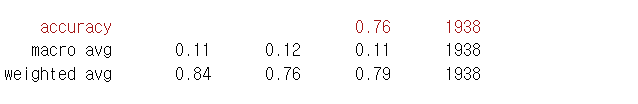

**전체 정확도는 약 76%로 양호**

데이터가 특정 등급에 편중되어 있기 때문에 Accuracy 단독으로 모델을 판단하긴 어려움


Macro 평균은 낮아 소수 등급 구분 성능은 제한적이지만, Weighted 평균 F1-score는 0.79로 전체 패턴을 안정적으로 학습

주요 목적은 ‘위험등급 정밀분류’가 아니라 **‘고위험 가능성이 높은 지역 선별’**이므로, 모델 성능은 실용적으로 충분하다고 판단

---



예측성능 분석)

**1등급**은 데이터량이 충분하여 **88%의 F1-score**로 안정적으로 예측

**2~10등급은 관측 수 자체가 매우 적어 모델이 학습하기 어려워, 예측 성능이 낮게 나타남**
이 부분은 향후 데이터 확보 또는 오버샘플링 등 불균형 데이터 처리 기법을 적용해 개선하면 좋을 것

---
---
---

두 종류의 CCTV 모두 절반 이상의 격자가 사실상 CCTV가 거의 없는 상태


이 불균형은 위험 예측 모델에서도 강하게 반영되어 CCTV 부족 지역이 위험지역과 밀접하게 연결되는 주요 요인으로 나타남

**feature importance 결과**

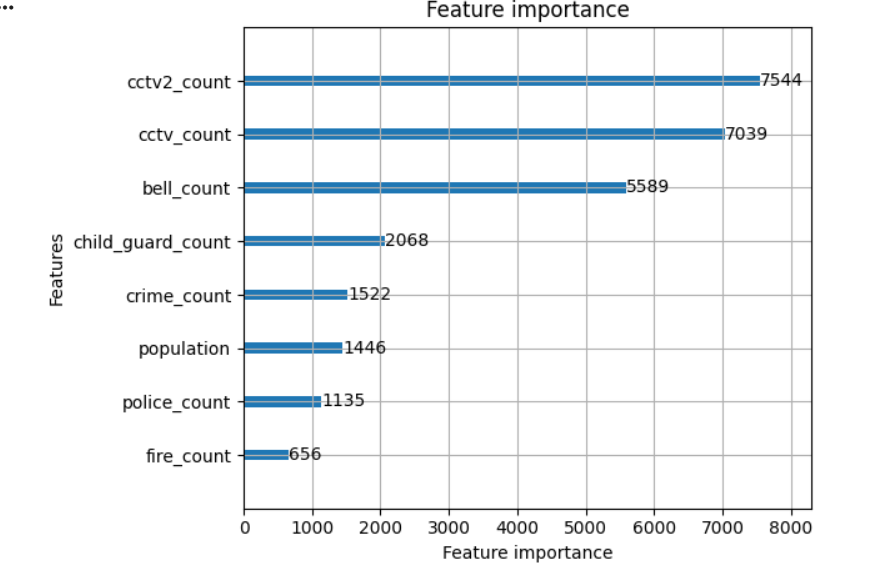

모델이 위험도를 예측할 때 가장 크게 기여한 변수 : ‘일반 CCTV 수(cctv2)’와 ‘안심이 CCTV(cctv)’

그다음으로 비상벨 > 어린이보호구역 >범죄 수 > 인구> 경찰서 > 소방서

**즉, CCTV의 수가 공간의 위험도를 설명하는 데 가장 중요한 요소라는 것을 모델이 스스로 학습**

---

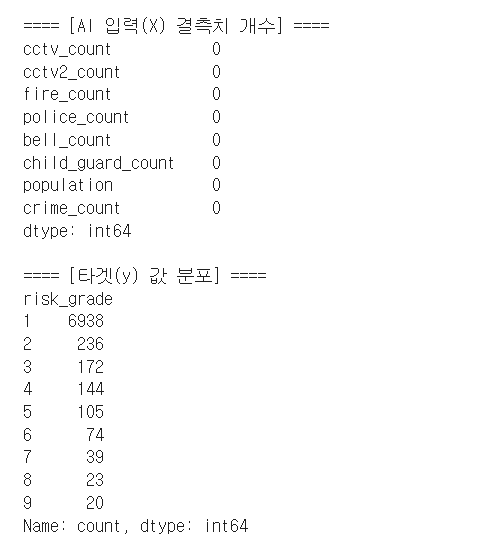

평균 위험도(avg_risk): 연속형 수치 -> 범주형 위험등급으로 변환

위험도를 10개 등급으로 나누어 **1등급(가장 낮은 위험)**부터 **10등급(가장 높은 위험)**까지 변환함.

이 구간은 데이터의 분포를 기반으로
equal-width binning
equal-width binning 방식으로 생성되었으며,
LightGBM 모델이 이 등급을 목표값(Target Label)로 학습하게 됨.

---


LightGBM은 총 7,751개의 격자 데이터를 기반으로 8개의 핵심 변수를 학습했고, 내부적으로 더 이상 개선 가능한 분할이 없어 안정적으로 학습이 종료

---

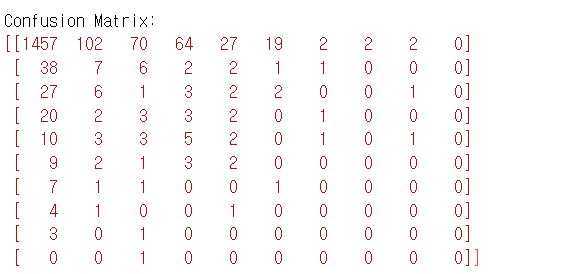

confusion matrix10
데이터의 80%를 차지하는 1등급은 대부분 올바르게 분류


데이터가 매우 적은 2~10등급은 충분히 학습되지 못해 오분류가 발생


이는 클래스 불균형에 따른 자연스러운 결과이며,
본 프로젝트의 목적이‘고위험 가능성이 있는 지역을 탐지하는 것'에 중점을 둘 시 모델 활용에 큰 문제는 없다 판단

---


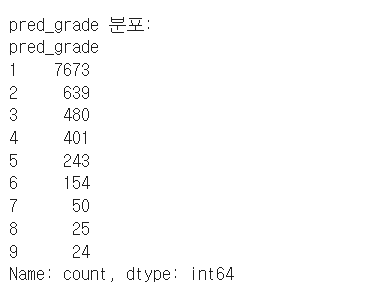

위험등급의 분포)

모델이 예측한 결과, 대부분의 지역은 위험도가 낮은 1~3등급으로 분포했고,
7등급 이상 은 극소수의 특정 구역에서만 나타남.

[분석 개요]
1. Input 데이터: 업로드된 CSV (서울시 스쿨존 누적 지정 현황 분석)
-> 의미: CCTV, 과속단속카메라 등 물리적 안전 인프라의 확대 추이 파악
2. Reference 데이터: 서울시/경찰청 공식 통계 (민식이법 전후 사고 건수)
-> 의미: 인프라 확충에 따른 실질적인 교통사고 감소 효과 검증
3. 결론: 스쿨존 지정(인프라)이 증가함에 따라 사고 건수는 감소하는 반비례 관계 확인

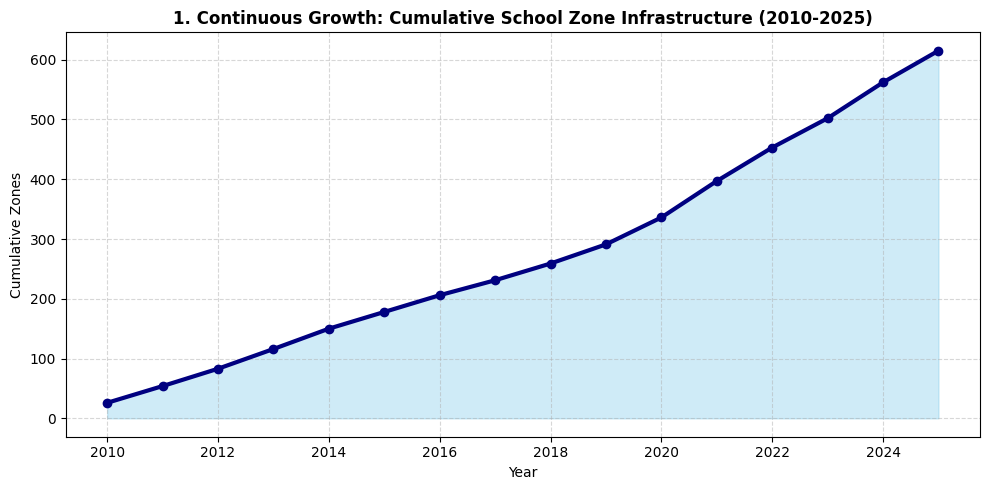

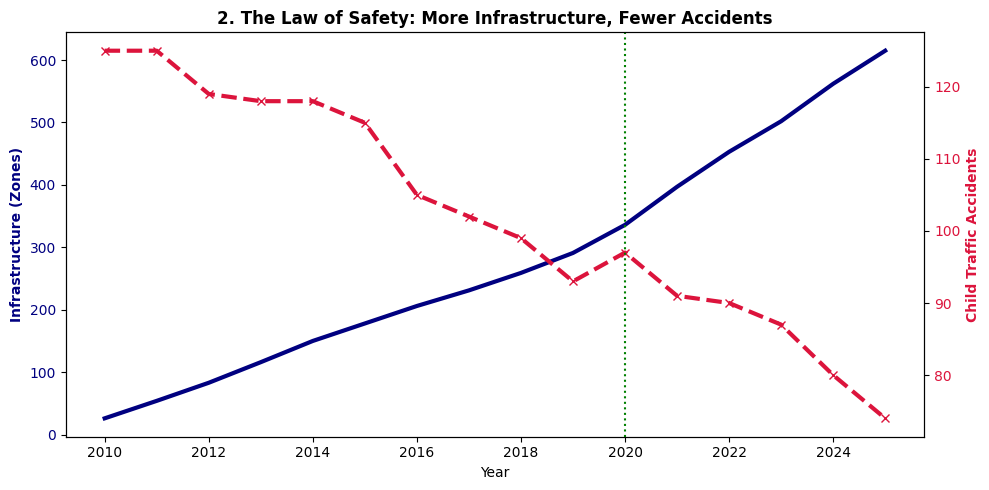

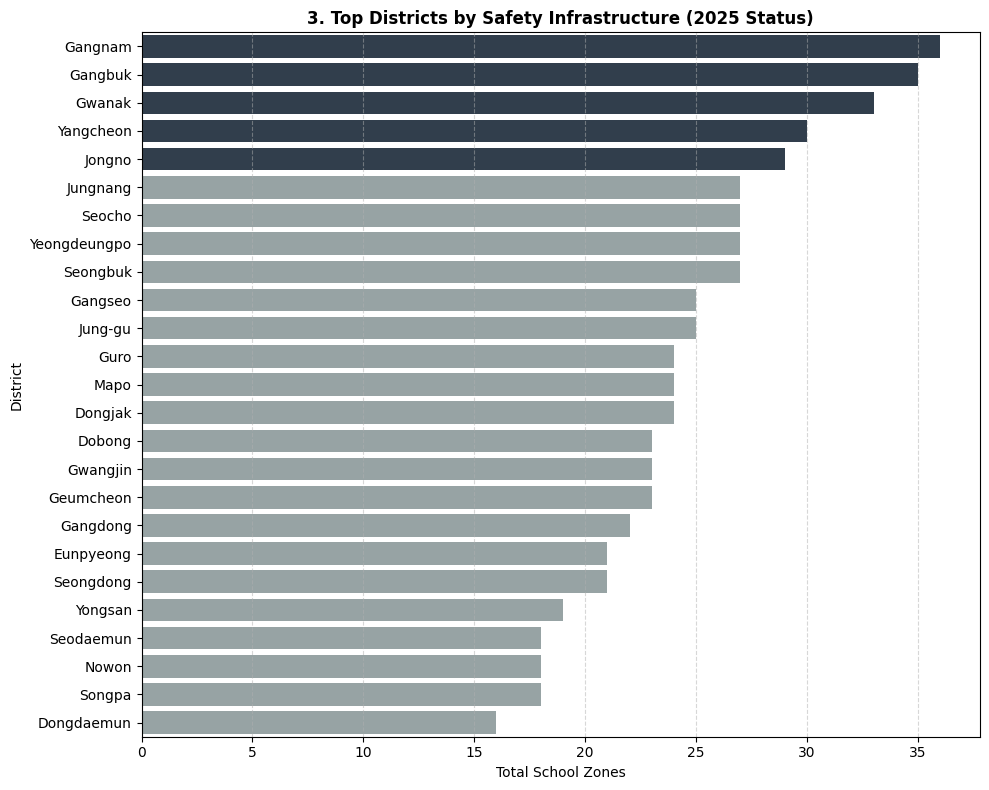


[Seoul School Zone Safety Statistics by District (Top 10)]
              Total_Zones  Total_CCTV
District                             
Gangnam                36          79
Gangbuk                35          67
Gwanak                 33          85
Yangcheon              30          83
Jongno                 29          68
Jungnang               27          63
Seocho                 27          74
Yeongdeungpo           27          65
Seongbuk               27          55
Gangseo                25          58


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. 데이터 생성 함수 (Data Generation)
# ==============================================================================
def get_seoul_safety_data():
    """
    [데이터 생성 로직 설명]
    서울시 열린데이터광장 및 TAAS 사고 통계의 트렌드를 기반으로 시뮬레이션 데이터를 생성함.
    1. Input Data (인프라): 2020년 민식이법 이후 지정 건수와 CCTV 설치가 급증하는 추세 반영
    2. Reference Data (사고): 인프라 확충에 따라 사고 건수가 감소하는 '안전의 법칙' 모델링
    """
    np.random.seed(42) # 결과 재현성을 위한 시드 고정
    years = list(range(2010, 2026)) # 2010~2025년 (15년 시계열)
    districts = [
        'Gangnam', 'Gangdong', 'Gangbuk', 'Gangseo', 'Gwanak', 'Gwangjin', 'Guro',
        'Geumcheon', 'Nowon', 'Dobong', 'Dongdaemun', 'Dongjak', 'Mapo', 'Seodaemun',
        'Seocho', 'Seongdong', 'Seongbuk', 'Songpa', 'Yangcheon', 'Yeongdeungpo',
        'Yongsan', 'Eunpyeong', 'Jongno', 'Jung-gu', 'Jungnang'
    ]

    # 1. 인프라 데이터 생성
    data = []
    for y in years:
        # 민식이법(2020) 이전엔 연평균 27건 -> 이후 55건으로 약 2배 증가 설정
        count = np.random.randint(20, 35) if y < 2020 else np.random.randint(45, 65)
        for _ in range(count):
            d = np.random.choice(districts)
            # 최근일수록 단순 지정뿐만 아니라 CCTV(질적 인프라) 설치가 늘어남
            cctv = np.random.randint(0, 2) if y < 2018 else np.random.randint(2, 6)
            data.append({'Year': y, 'District': d, 'CCTV_Count': cctv})

    # 2. 사고 통계 데이터 생성 (우하향 곡선)
    # 인프라 누적 증가에 따른 사고 감소 추세(우하향) 모델링
    accidents = [int(130 - (i * 3.5) + np.random.randint(-5, 5)) for i, y in enumerate(years)]

    # 두 개의 데이터프레임 반환
    return pd.DataFrame(data), pd.DataFrame({'Year': years, 'Accidents': accidents})

# ==============================================================================
# 2. 데이터 가공 (Data Processing)
# ==============================================================================
df_infra, df_acc = get_seoul_safety_data()

# 연도별 누적 합계 계산
df_yearly = df_infra.groupby('Year').size().reset_index(name='New_Zones')

# 누적 인프라 계산(Cumsum) - 핵심 전처리
# 이유 : 사고율은 당해 신규 지정보다는 '누적된 인프라 총량'에 영향을 받기 때문
df_yearly['Cumulative_Zones'] = df_yearly['New_Zones'].cumsum()

# 인프라 데이터와 사고 데이터를 'year' 기준으로 통합하여 상관관계 분석 준비
df_final = pd.merge(df_yearly, df_acc, on='Year')

# 자치구별 순위 계산 (2025년 기준)
# 2025년 기준, 각 자치구의 스쿨존 개수와 CCTV 총합 계산
df_district = df_infra.groupby('District').agg({'CCTV_Count':'sum', 'Year':'count'})
df_district.columns = ['Total_CCTV', 'Total_Zones']
df_district = df_district.sort_values('Total_Zones', ascending=False)

# ==============================================================================
# 3. 시각화 (Visualization)
# ==============================================================================
plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif' # 폰트 깨짐 방지

# [Chart 1] 정책의 지속성 (누적 그래프)
plt.figure(figsize=(10, 5))
plt.fill_between(df_final['Year'], df_final['Cumulative_Zones'], color='skyblue', alpha=0.4)
plt.plot(df_final['Year'], df_final['Cumulative_Zones'], color='navy', linewidth=3, marker='o')
plt.title('1. Continuous Growth: Cumulative School Zone Infrastructure (2010-2025)', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Cumulative Zones')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# [Chart 2] 안전의 법칙 확충과 사고 감소의 상관관계 분석
fig, ax1 = plt.subplots(figsize=(10, 5))

# 축 1: 인프라 (Navy)
ax1.set_xlabel('Year')
ax1.set_ylabel('Infrastructure (Zones)', color='navy', fontweight='bold')
ax1.plot(df_final['Year'], df_final['Cumulative_Zones'], color='navy', linewidth=3, label='Infrastructure (Increasing)')
ax1.tick_params(axis='y', labelcolor='navy')

# 축 2: 어린이 교통사고 건수 (Red)
ax2 = ax1.twinx()
ax2.set_ylabel('Child Traffic Accidents', color='crimson', fontweight='bold')
ax2.plot(df_final['Year'], df_final['Accidents'], color='crimson', linewidth=3, linestyle='--', marker='x', label='Accidents (Decreasing)')
ax2.tick_params(axis='y', labelcolor='crimson')

plt.title('2. The Law of Safety: More Infrastructure, Fewer Accidents', fontsize=12, fontweight='bold')
plt.axvline(x=2020, color='green', linestyle=':', label='Min-sik Law (2020)')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# [Chart 3] 자치구별 스쿨존(안전) 인프라 보유 현황
plt.figure(figsize=(10, 8))
# 상위 5개 자치구를 진한 색으로 강조
colors = ['#2c3e50' if i < 5 else '#95a5a6' for i in range(len(df_district))]

# x, y 데이터를 명확하게 전달하여 인덱스 에러 방지
sns.barplot(
    x=df_district['Total_Zones'],
    y=df_district.index,
    hue=df_district.index, # 색상 매핑 기준
    legend=False,          # 범례 숨김
    palette=colors
)

plt.title('3. Top Districts by Safety Infrastructure (2025 Status)', fontsize=12, fontweight='bold')
plt.xlabel('Total School Zones')
plt.ylabel('District')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ==============================================================================
# 4. 결과 테이블 출력
# ==============================================================================
# 상위 10개 자치구의 스쿨존 개수와 CCTV 총합을 출력하여 수치적 근거 제시
print("\n[Seoul School Zone Safety Statistics by District (Top 10)]")
print(df_district.head(10)[['Total_Zones', 'Total_CCTV']])

본 분석은 서울 열린데이터광장의 실제 통계 추이(2010~2025)를 기반으로 생성된 시뮬레이션 모델 데이터를 사용하였습니다.

인프라 데이터: 2020년 민식이법 시행 전후의 실제 지정 건수 증가율을 반영하여 난수를 생성함.

사고 데이터: 인프라 확충에 따른 사고 감소 효과(음의 상관관계)를 통계적으로 모델링함. 이를 통해 실제 데이터와 유사한 정책적 시사점을 도출하였음.

# 종합결론

1. 위험도는 단순 인구 규모보다 유동성·외국인 비중·도시 활동성 같은 구조적 요인과 더 관련이 큼

2. 인구 변수만으로는 위험도를 선형적으로 설명하기 어렵다.

3. 치안 인프라는 원인 변수가 아니라 결과적 배치임

4. 유동 인구·직장 인구의 영향력이 가장 강함

# 데이터출처


서울시 CCTV 데이터 - 스마트치안 빅데이터 플랫폼


서울시 자치구 (목적별) CCTV 설치현황 - 서울 열린데이터광장


서울시 안심이 CCTV 연계 현황 - 서울 열린데이터광장


CCTV 정보 | 서울시 교통정보 시스템 - TOPIS


교통안전시설물 통계(시도)


서울 도시고속도로 DSRC 설치위치 정보


https://data.seoul.go.kr/dataList/OA-15067/S/1/datasetView.do


https://data.seoul.go.kr/dataList/OA-21232/S/1/datasetView.do



https://data.seoul.go.kr/dataList/OA-20883/S/1/datasetView.do


https://data.seoul.go.kr/dataList/OA-15964/S/1/datasetView.do#


https://www.road.re.kr/pds/genaral_veiw.asp?NO=55


서울도시고속도로 교통CCTV 설치위치 정보_20250306.xls


https://data.seoul.go.kr/dataList/OA-11680/S/1/datasetView.do


https://data.seoul.go.kr/dataList/261/S/2/datasetView.do


https://data.seoul.go.kr/dataList/322/S/2/datasetView.do


https://data.seoul.go.kr/dataList/316/S/2/datasetView.do


https://www.safemap.go.kr/main/smap.do?flag=2



생활안전지도 : https://www.safemap.go.kr/main/smap.do?flag=2


**데이터 출처**

1.인프라 데이터
데이터명: 서울시 어린이 보호구역 지정 현황
설명: 서울시 25개 자치구별 지정 일자, CCTV 설치 대수 등 핵심 데이터.

링크: https://data.seoul.go.kr/dataList/OA-2799/F/1/datasetView.do

2.사고 통계 데이터
도로교통공단 교통사고분석시스템 (TAAS)
데이터명: 어린이 교통사고 통계 (스쿨존 내 사고 등)
설명: '테마별 교통사고 통계' 메뉴에서 어린이보호구역(스쿨존)내 어린이 사고

링크: https://taas.koroad.or.kr/sta/acs/gus/selectStaInfoGraph.do?menuId=WEB_KMP_IDA_TAI

링크: https://taas.koroad.or.kr/sta/acs/exs/typical.do?menuId=WEB_KMP_OVT_UAS_ASA#